In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", 999)
import uproot
import os
from multiprocessing import Pool
import psutil

import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())

2024-01-28 16:06:42.465794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 16:06:42.841929: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.10.0
True


In [2]:
def get_min(Ref, Array):
    return np.argmin(np.abs(Ref - Array))

In [3]:
ReadList = ["Mass", "evt_trig",
        "fourjetmasstev", "Mjj_avg_dRpairing_GeV",

        #"Mjj_msortedP1_high_div4jm", "Mjj_msortedP1_low_div4jm",
        #"Mjj_msortedP2_high_div4jm", "Mjj_msortedP2_low_div4jm",
        #"Mjj_msortedP3_high_div4jm", "Mjj_msortedP3_low_div4jm",

        "P1high_MTeV", "P1low_MTeV",
        "P2high_MTeV", "P2low_MTeV",
        "P3high_MTeV", "P3low_MTeV",

        "P1high_dR", "P1low_dR",
        "P2high_dR", "P2low_dR",
        "P3high_dR", "P3low_dR",]

In [4]:
def add_more_cols(DF):
    DF["P1high_M"] = DF["P1high_MTeV"] * 1000
    DF["P1low_M"] = DF["P1low_MTeV"] * 1000
    DF["P2high_M"] = DF["P2high_MTeV"] * 1000
    DF["P2low_M"] = DF["P2low_MTeV"] * 1000
    DF["P3high_M"] = DF["P3high_MTeV"] * 1000
    DF["P3low_M"] = DF["P3low_MTeV"] * 1000
    
    DF["P1M"] = (DF["P1high_M"] + DF["P1low_M"]) / 2
    DF["P2M"] = (DF["P2high_M"] + DF["P2low_M"]) / 2
    DF["P3M"] = (DF["P3high_M"] + DF["P3low_M"]) / 2
    
    DF["dRi"] = DF.apply(lambda row: get_min(row["Mjj_avg_dRpairing_GeV"], 
                                np.array([row["P1M"], row["P2M"], row["P3M"]])), axis = 1)
    DF["Truth_high"] = DF.apply(lambda row: get_min(row["Mass"],
                                np.array([row["P1high_M"], row["P2high_M"], row["P3high_M"]])), axis = 1)
    DF["Truth_avg"] = DF.apply(lambda row: get_min(row["Mass"], 
                                np.array([row["P1M"], row["P2M"], row["P3M"]])), axis = 1)
    
    DF["P1QSMD"] = (DF["P1high_M"] - DF["Mass"])**2 + (DF["P1low_M"] - DF["Mass"])**2
    DF["P2QSMD"] = (DF["P2high_M"] - DF["Mass"])**2 + (DF["P2low_M"] - DF["Mass"])**2
    DF["P3QSMD"] = (DF["P3high_M"] - DF["Mass"])**2 + (DF["P3low_M"] - DF["Mass"])**2
    
    DF["Truth_QSMD"] = DF.apply(lambda row: get_min(0, 
                                np.array([row["P1QSMD"], row["P2QSMD"], row["P3QSMD"]])), axis = 1)

In [5]:
def make_training_and_testing_pd(Input):
    FileName = "ML_TTree/tree_ML_MCRun2_"
    if isinstance(Input, str):
        FileName = FileName + Input  + ".root"
    else:
        FileName = FileName + str(Input) + "GeV.root"
    
    print("Processing file: " + FileName + "\n")
    Events = uproot.open(FileName)["tree_ML"]
    DF = Events.arrays(ReadList, library="pd")
    
    DF = DF.loc[DF["evt_trig"] == 1].reset_index(drop=True)
    
    add_more_cols(DF)
    
    TrainingDF = None
    TestingDF = None
    TrainingRows = 100000
    TestingRows = 50000
    
    if isinstance(Input, str):
        ### Each resonant signal only has ~90k events. So use all in training ###
        TrainingDF = DF
        TestingDF = DF.loc[0:TestingRows-1]
    else:
        TrainingDF = DF.loc[0:TrainingRows-1]
        TestingDF = DF.loc[TrainingRows:TrainingRows+TestingRows-1]
    
    
    return [TrainingDF, TestingDF]

In [6]:
InputList = [500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2500, 3000,
             "Ms2000_Mc500", "Ms4000_Mc1000", "Ms6000_Mc1600", "Ms8000_Mc2000", "Ms9000_Mc2250", "Ms8000_Mc3000"]

SanityCheckPlots = True

In [7]:
#multithreading and memory monitoring in case large input files in the future
Mem0 = psutil.virtual_memory().available

TrainingDF = None
TestingDF = None
with Pool(processes=6) as pool:
    DFarray = pool.map(make_training_and_testing_pd, InputList)
    TrainingDF =pd.concat([row[0] for row in DFarray], ignore_index=True)
    TestingDF = pd.concat([row[1] for row in DFarray], ignore_index=True)

Mem1 = psutil.virtual_memory().available
print("Memory used: " + str((Mem0 - Mem1)/(1024**3)) + "GB")

Processing file: ML_TTree/tree_ML_MCRun2_500GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_900GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_700GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_600GeV.root


Processing file: ML_TTree/tree_ML_MCRun2_800GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_1000GeV.root




Processing file: ML_TTree/tree_ML_MCRun2_1250GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1750GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2000GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_3000GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_Ms2000_Mc500.root

Processing file: ML_TTree/tree_ML_MCRun2_Ms4000_Mc1000.root

Processing file: ML_TTree/tree_ML_MCRun2_Ms6000_Mc1600.root

Processing file: ML_TTree/tree_ML_MCRun2_Ms8000_Mc2000.root

Processing file: ML_TTree/tree_ML_MCRun2_Ms9000_Mc2250.root

Processing file: ML_TTree/tree_ML_MCRun2_

In [8]:
#remove a mass point in training and check its performace in testing
#TrainingDF = TrainingDF.loc[TrainingDF["Mass"] != 3000]
TrainingDF

Mass  evt_trig  fourjetmasstev  Mjj_avg_dRpairing_GeV  P1high_MTeV  \
0         500         1        1.437438             498.926239     0.847387   
1         500         1        1.372216             564.356628     1.003741   
2         500         1        2.415887             681.370911     1.869017   
3         500         1        1.927872             706.945679     1.135702   
4         500         1        1.149871             290.337799     0.852893   
...       ...       ...             ...                    ...          ...   
1744793  3000         1        6.535932            1307.568726     5.377786   
1744794  3000         1        5.224732            1815.273438     2.882598   
1744795  3000         1        7.592826            2795.988281     3.582301   
1744796  3000         1        6.927839            2594.281738     3.575580   
1744797  3000         1        7.145230            2468.741699     4.100414   

         P1low_MTeV  P2high_MTeV  P2low_MTeV  P3high_MTeV  P3low_MTeV  \
0          0.330702     0.694555    0.515225     0.535663    0.462190   
1          0.124972     0.495314    0.481617     0.447687    0.432799   
2          0.353732     1.018949    0.484321     0.788478    0.574264   
3          0.642779     0.956883    0.457008     0.883534    0.342234   
4          0.145379     0.479999    0.410948     0.374831    0.205845   
...             ...          ...         ...          ...         ...   
1744793    0.660737     2.650431    1.764363     1.405020    1.210117   
1744794    1.822171     2.629615    1.000931     2.591036    1.091268   
1744795    3.522391     3.438700    2.153276     2.932984    2.748832   
1744796    2.809887     2.832127    2.356437     2.788135    2.505780   
1744797    0.837070     3.420094    2.753098     2.956290    2.420709   

         P1high_dR  P1low_dR  P2high_dR  P2low_dR  P3high_dR  P3low_dR  \
0         3.089752  1.379493   3.153736  3.200309   2.218899  1.855463   
1         2.356613  0.886480   2.217569  2.160642   1.778389  1.928236   
2         4.947482  1.604383   3.160335  2.463268   2.392548  2.640573   
3         3.497897  2.925978   3.030278  1.301696   2.581672  1.942842   
4         2.693075  1.199901   2.256340  2.585560   1.434048  1.062791   
...            ...       ...        ...       ...        ...       ...   
1744793   2.720518  1.605185   2.551869  2.701236   1.115265  1.293146   
1744794   3.060042  2.335114   2.170200  1.137318   2.177055  1.220143   
1744795   2.838997  2.578493   2.086794  1.545883   2.495052  2.739778   
1744796   3.536083  2.532907   2.134949  1.697465   2.161088  2.102989   
1744797   2.361829  0.737859   2.812449  2.829778   2.170641  2.091993   

            P1high_M      P1low_M     P2high_M      P2low_M     P3high_M  \
0         847.386945   330.702499   694.554697   515.224642   535.662752   
1        1003.740833   124.972475   495.314189   481.617453   447.686767   
2        1869.017332   353.732193  1018.949055   484.321434   788.477532   
3        1135.701841   642.779060   956.883294   457.008091   883.534240   
4         852.893143   145.378714   479.999201   410.947632   374.831089   
...              ...          ...          ...          ...          ...   
1744793  5377.786221   660.737393  2650.430621  1764.362980  1405.020089   
1744794  2882.598166  1822.171334  2629.615350  1000.931469  2591.036068   
1744795  3582.301032  3522.390955  3438.700498  2153.276067  2932.983702   
1744796  3575.580265  2809.887061  2832.126901  2356.436568  2788.135382   
1744797  4100.413916   837.069690  3420.093789  2753.098349  2956.290429   

             P3low_M          P1M          P2M          P3M  dRi  Truth_high  \
0         462.189755   589.044722   604.889669   498.926253    2           2   
1         432.799034   564.356654   488.465821   440.242900    0           1   
2         574.264262  1111.374763   751.635244   681.370897    2           2   
3         342.234189   889.240451   706.945693   612.884215  

In [9]:
TrainingDF.dtypes

Mass                       int32
evt_trig                   int32
fourjetmasstev           float64
Mjj_avg_dRpairing_GeV    float32
P1high_MTeV              float64
P1low_MTeV               float64
P2high_MTeV              float64
P2low_MTeV               float64
P3high_MTeV              float64
P3low_MTeV               float64
P1high_dR                float64
P1low_dR                 float64
P2high_dR                float64
P2low_dR                 float64
P3high_dR                float64
P3low_dR                 float64
P1high_M                 float64
P1low_M                  float64
P2high_M                 float64
P2low_M                  float64
P3high_M                 float64
P3low_M                  float64
P1M                      float64
P2M                      float64
P3M                      float64
dRi                        int64
Truth_high                 int64
Truth_avg                  int64
P1QSMD                   float64
P2QSMD                   float64
P3QSMD    

In [10]:
Masses = sorted(set(TrainingDF["Mass"]))
print(Masses)

[500, 600, 700, 800, 900, 1000, 1250, 1500, 1600, 1750, 2000, 2250, 2500, 3000]


In [11]:
TrainingDF = TrainingDF.sample(frac = 1)
TrainingDF

Mass  evt_trig  fourjetmasstev  Mjj_avg_dRpairing_GeV  P1high_MTeV  \
1288894  1000         1        3.826279             973.986511     2.000111   
1237490   500         1        2.025095             502.304626     1.383533   
1312441  1000         1        3.774175             896.761353     3.097226   
1132342  3000         1        6.812924            2948.774658     5.659145   
469836    900         1        1.985001             694.945984     1.056968   
...       ...       ...             ...                    ...          ...   
719237   1500         1        2.914079             719.017700     1.471366   
967672   2000         1        3.890455             767.789185     1.965280   
528150   1000         1        2.188424             601.149963     1.180898   
1692227  3000         1        7.747365            2283.216797     4.737992   
256836    700         1        1.349756             290.186401     0.700481   

         P1low_MTeV  P2high_MTeV  P2low_MTeV  P3high_MTeV  P3low_MTeV  \
1288894    1.607421     1.891091    1.635171     0.975872    0.972101   
1237490    0.454789     1.013727    0.681561     0.520390    0.484220   
1312441    0.286420     1.673117    0.547935     1.019331    0.774191   
1132342    0.238404     2.912317    1.155824     1.617136    1.390817   
469836     0.332924     0.901547    0.873954     0.806999    0.703565   
...             ...          ...         ...          ...         ...   
719237     1.409850     1.319470    1.237964     0.877125    0.560910   
967672     1.723971     1.941622    1.842108     0.894263    0.641316   
528150     0.844670     1.048376    0.778278     0.966778    0.235522   
1692227    0.895587     4.200196    1.330937     4.176066    0.390367   
256836     0.627371     0.655286    0.580705     0.392186    0.188187   

         P1high_dR  P1low_dR  P2high_dR  P2low_dR  P3high_dR  P3low_dR  \
1288894   2.729450  2.804655   2.571517  2.695901   1.157309  1.026213   
1237490   2.674206  1.990691   3.008395  2.353849   1.302686  1.174393   
1312441   2.909304  1.466023   2.751726  1.411875   1.610089  2.044837   
1132342   3.866016  0.525951   3.198432  2.171107   1.774825  3.172625   
469836    2.276259  1.667443   2.493310  3.601361   2.388534  1.964298   
...            ...       ...        ...       ...        ...       ...   
719237    3.561921  2.685015   2.602110  2.282338   1.503458  0.988408   
967672    2.932992  2.942297   2.837113  2.791705   0.889940  0.717050   
528150    3.222697  2.711772   3.169469  2.118309   2.712001  0.755680   
1692227   2.399000  1.618272   2.176955  2.779988   2.170021  0.574908   
256836    3.027666  2.891619   2.323598  2.459365   1.115113  0.568681   

            P1high_M      P1low_M     P2high_M      P2low_M     P3high_M  \
1288894  2000.111219  1607.420622  1891.091059  1635.171211   975.871826   
1237490  1383.532915   454.788808  1013.726582   681.560905   520.389752   
1312441  3097.225791   286.419918  1673.116704   547.934884  1019.331348   
1132342  5659.144887   238.404477  2912.317032  1155.823925  1617.136163   
469836   1056.968018   332.923996   901.546863   873.953579   806.999185   
...              ...          ...          ...          ...          ...   
719237   1471.366423  1409.849837  1319.470409  1237.964411   877.125088   
967672   1965.279980  1723.970535  1941.622263  1842.108487   894.262546   
528150   1180.898091   844.670028  1048.375543   778.278179   966.778003   
1692227  4737.992047   895.587469  4200.195583  1330.937471  4176.066456   
256836    700.481246   627.370783   655.285779   580.705059   392.185692   

             P3low_M          P1M          P2M          P3M  dRi  Truth_high  \
1288894   972.101180  1803.765921  1763.131135   973.986503    2           2   
1237490   484.219510   919.160862   847.643744   502.304631    2           2   
1312441   774.191335  1691.822855  1110.525794   896.761342    2           2   
1132342  1390.817059  2948.774682  2034.070479  1503.976611  

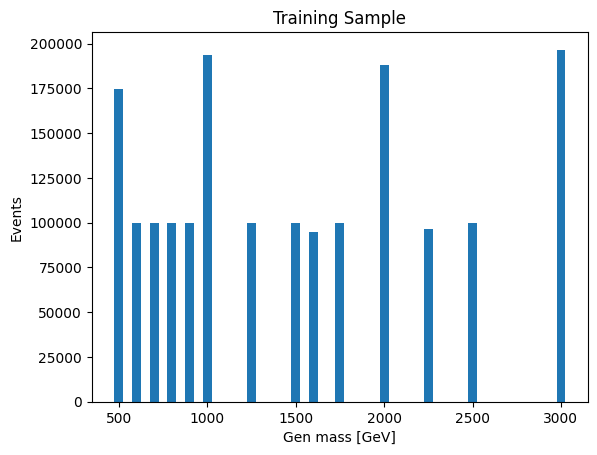

In [12]:
if SanityCheckPlots:
    plt.hist(TrainingDF["Mass"], bins = int((Masses[-1] - Masses[0])/50) + 1,
             range = [Masses[0]-25, Masses[-1]+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Training Sample")

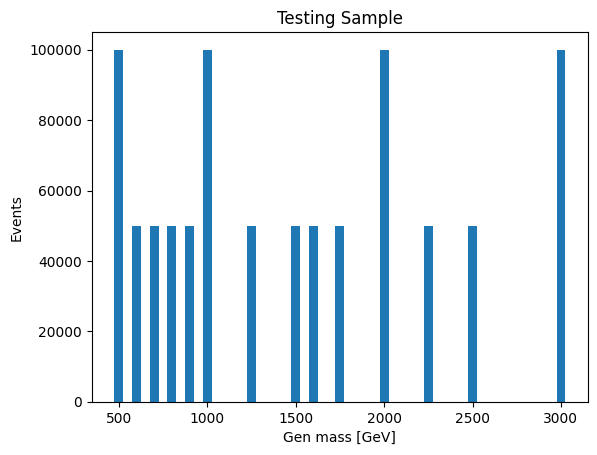

In [13]:
if SanityCheckPlots:
    plt.hist(TestingDF["Mass"], bins = int((Masses[-1] - Masses[0])/50) + 1,
             range = [Masses[0]-25, Masses[-1]+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Testing Sample")

/tmp/ipykernel_1396/1985655967.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


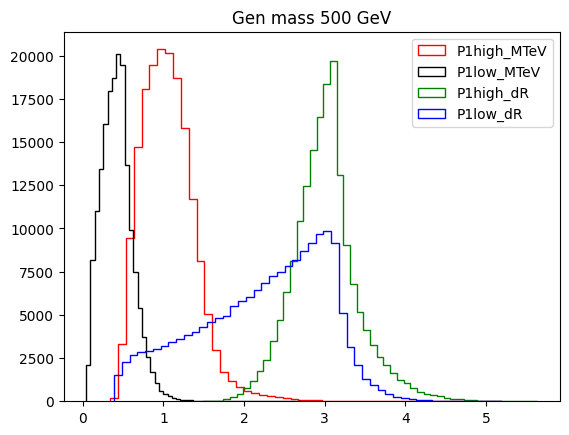

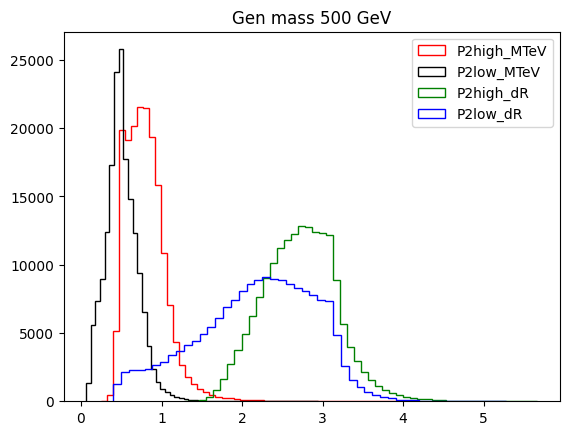

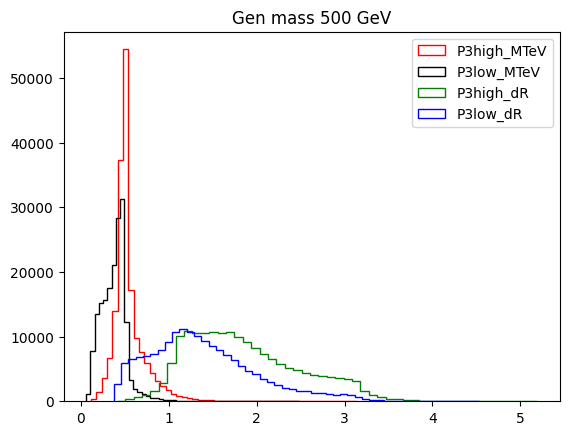

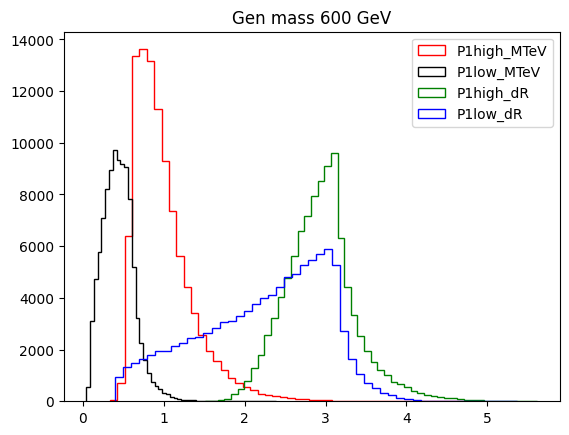

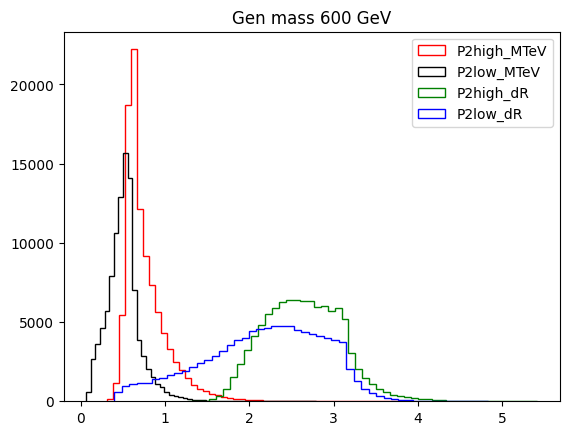

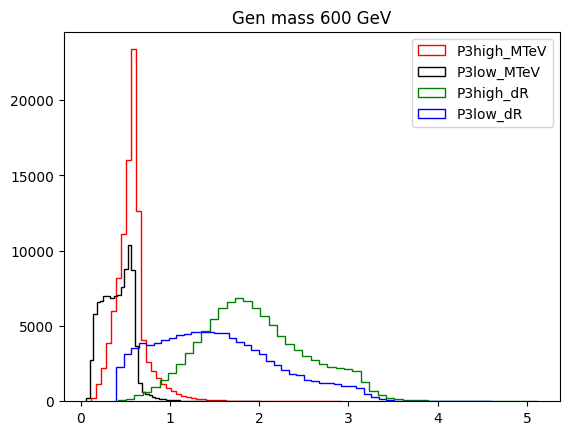

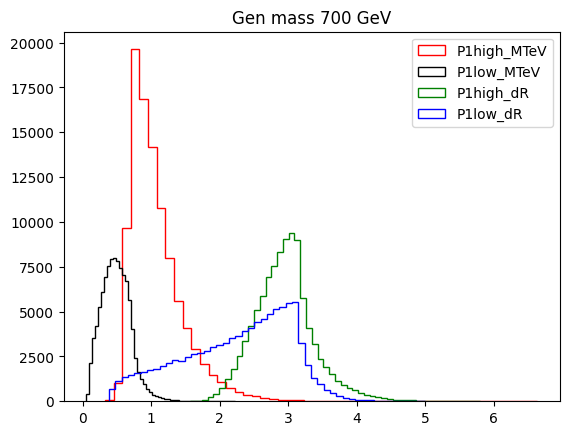

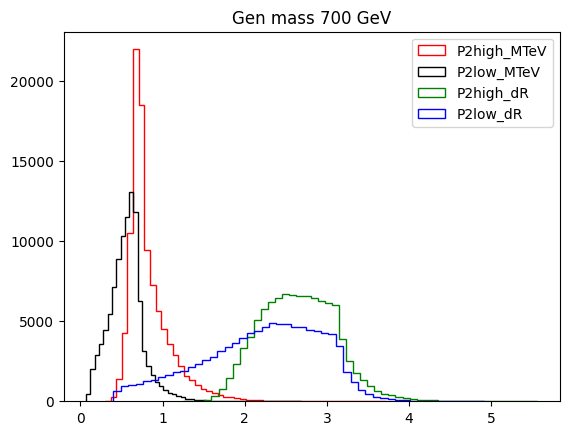

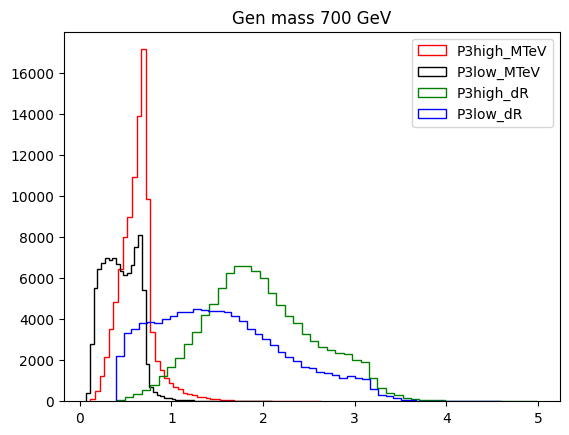

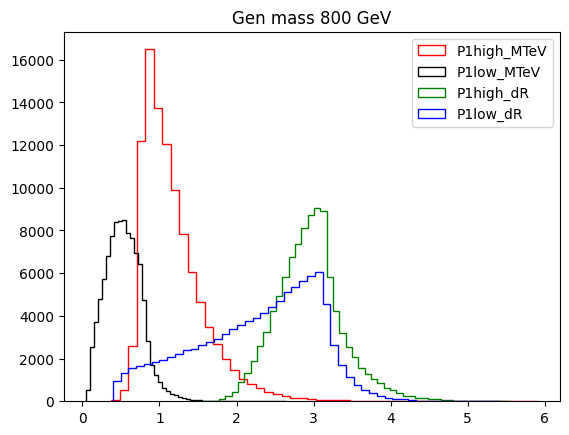

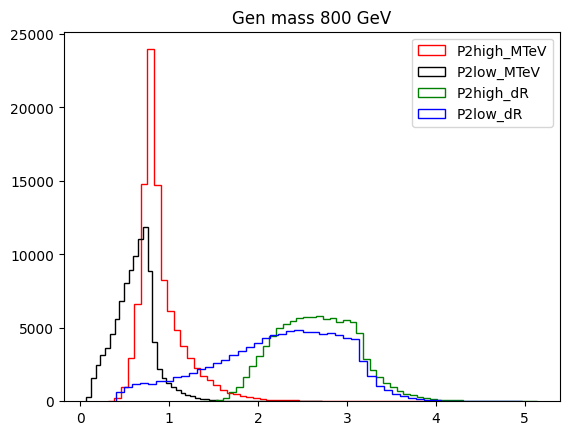

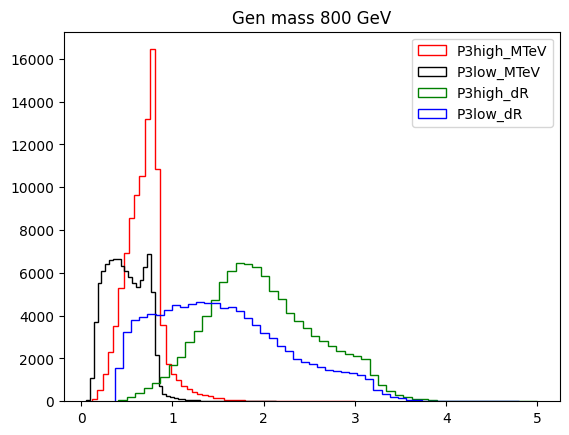

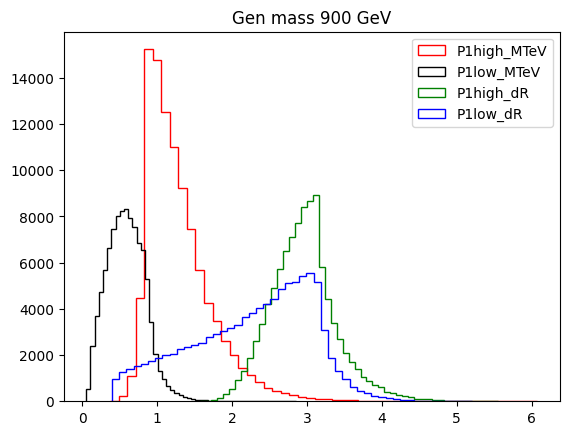

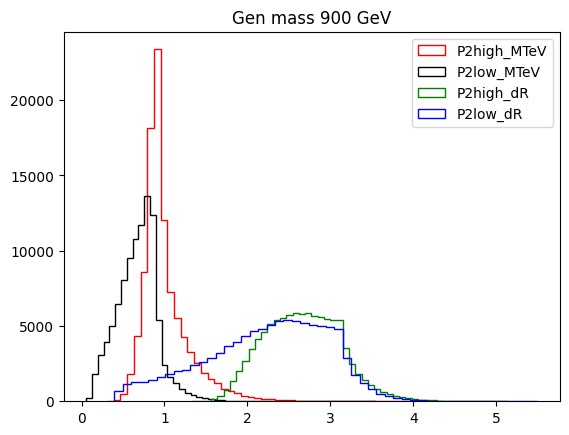

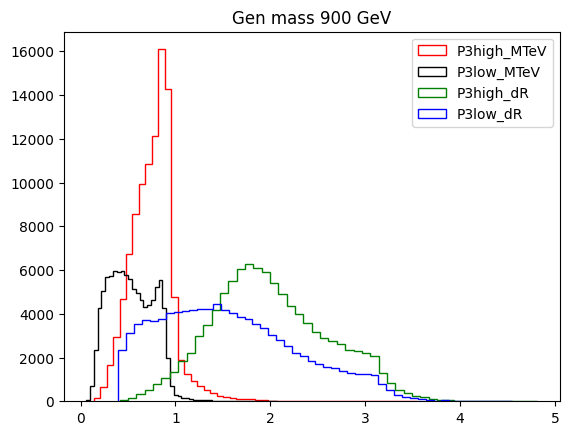

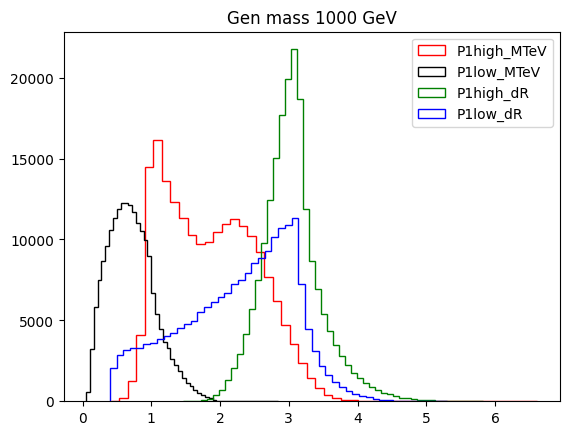

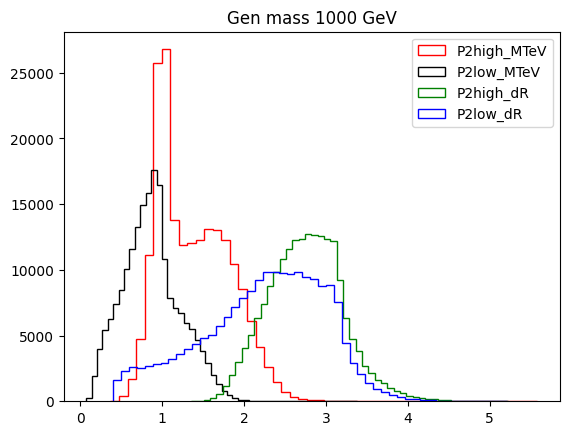

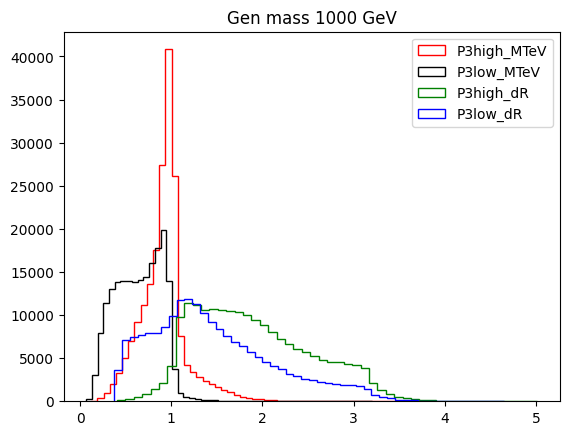

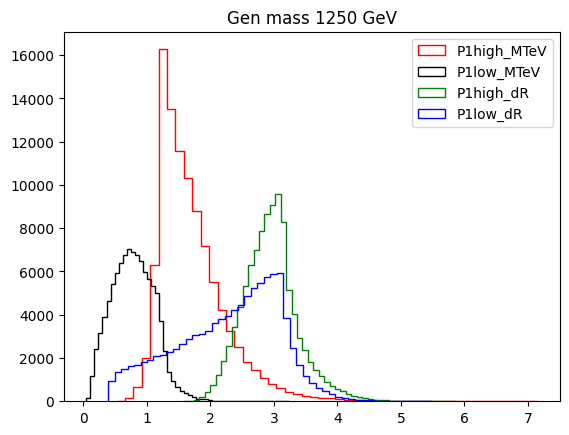

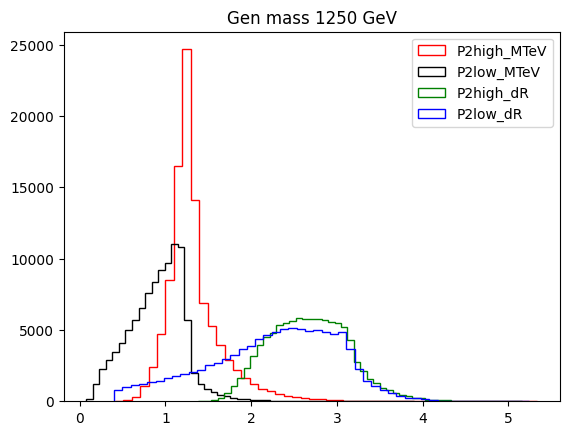

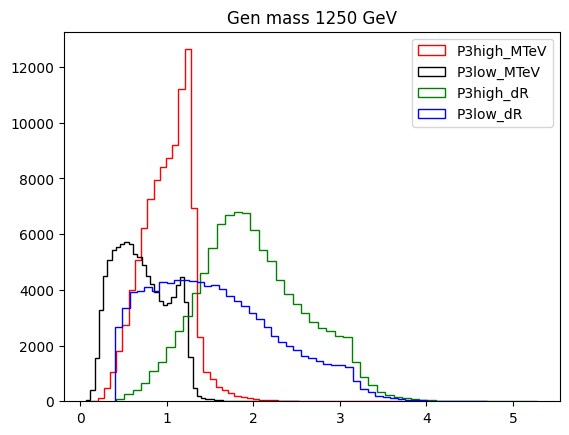

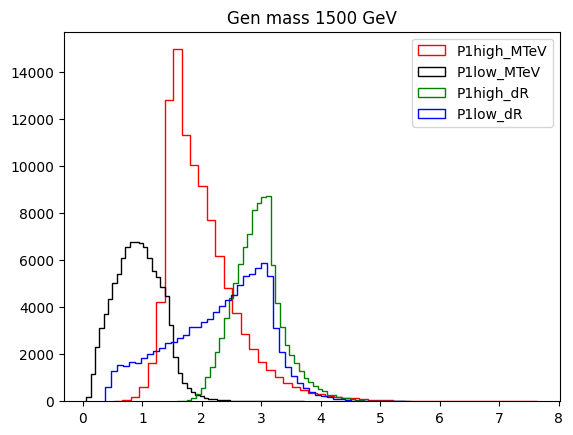

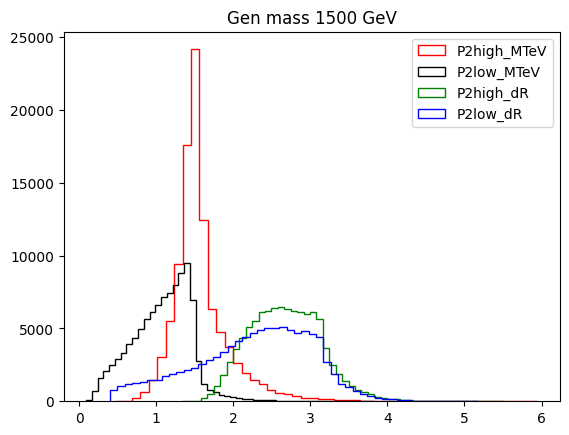

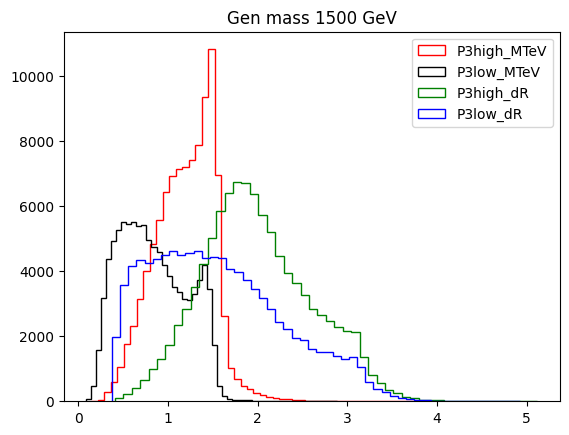

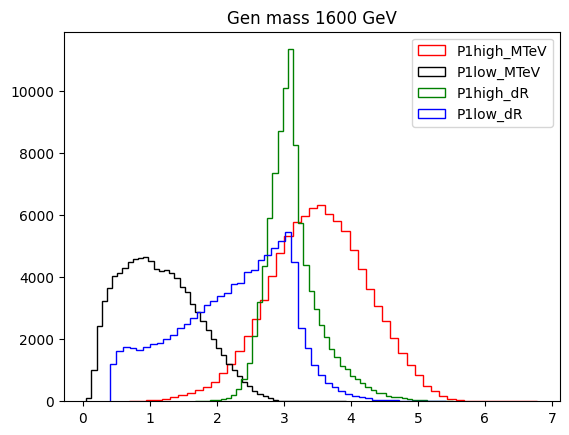

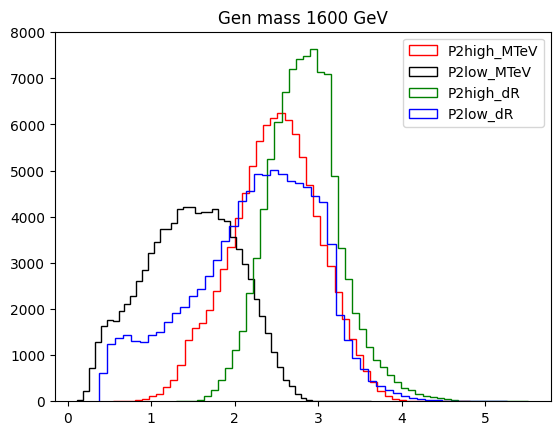

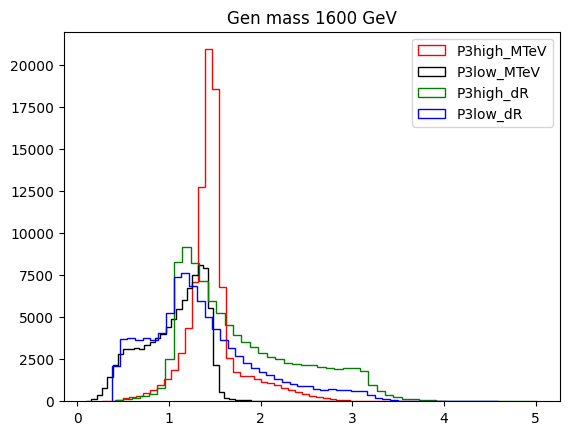

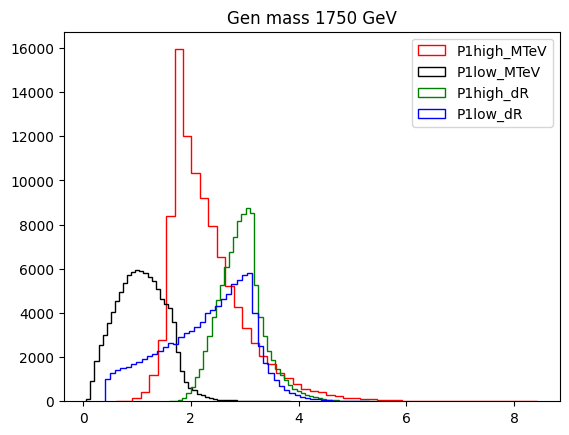

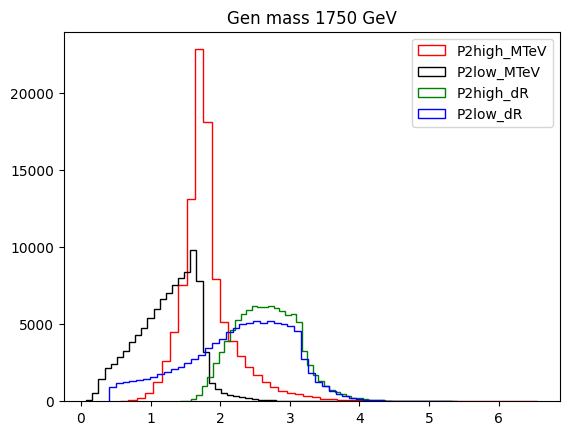

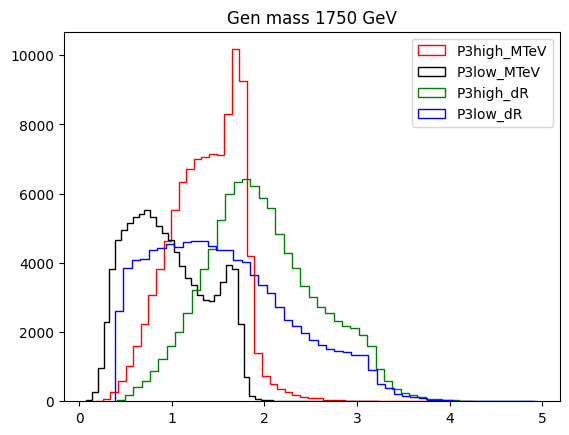

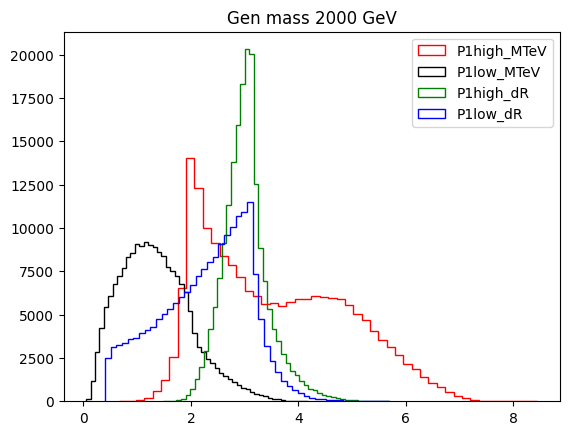

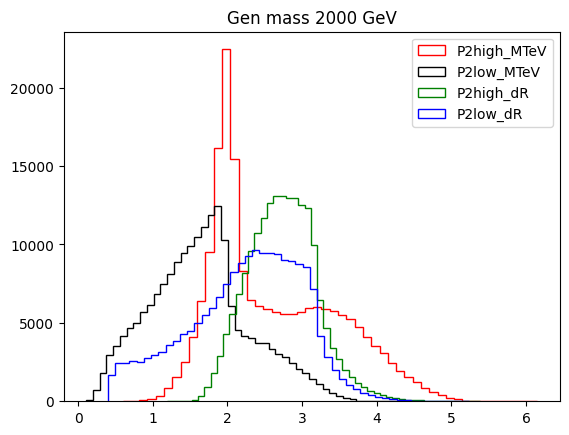

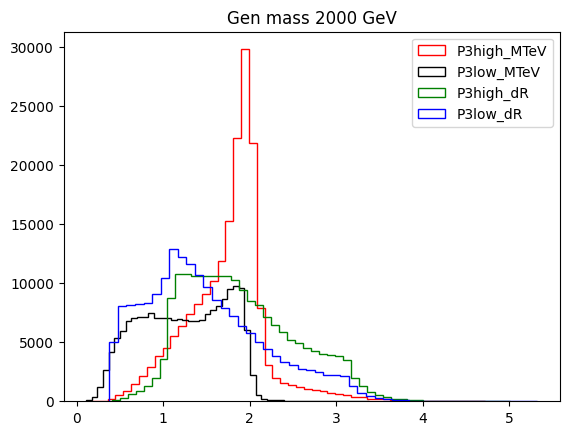

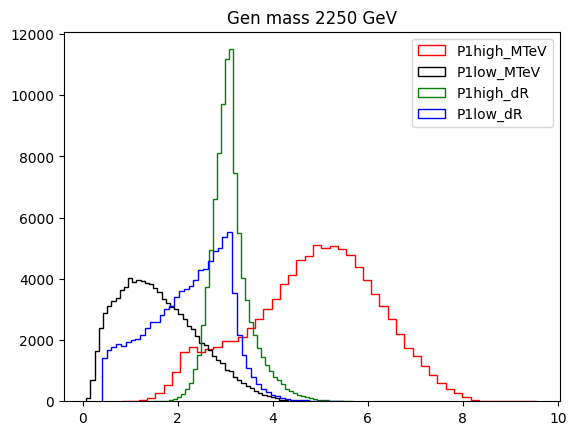

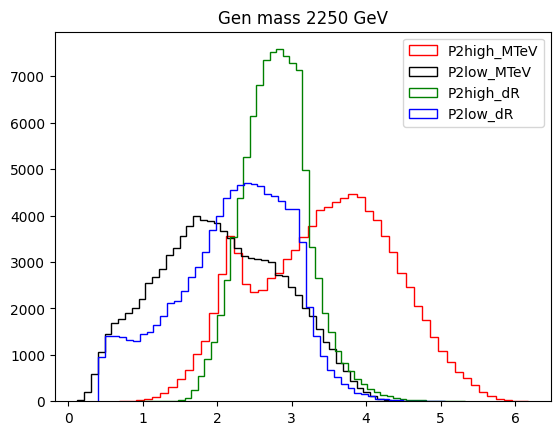

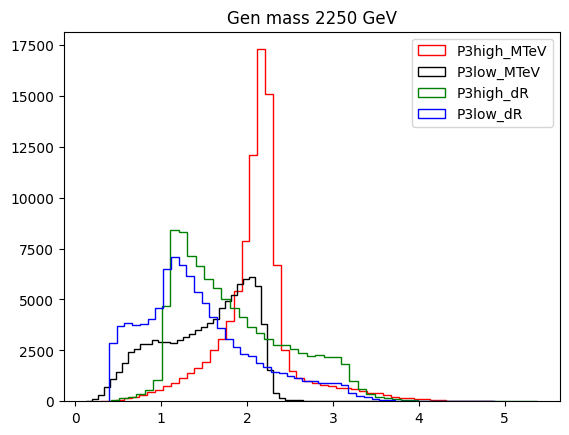

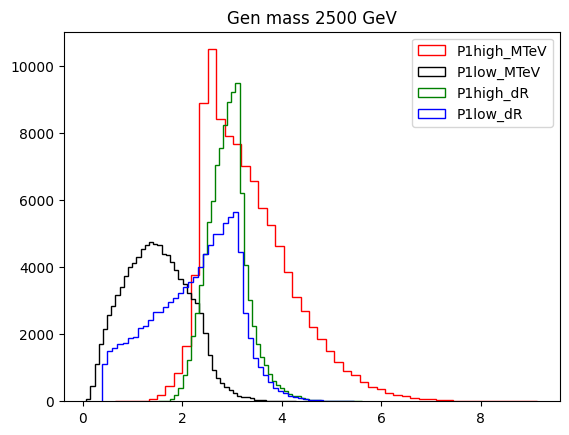

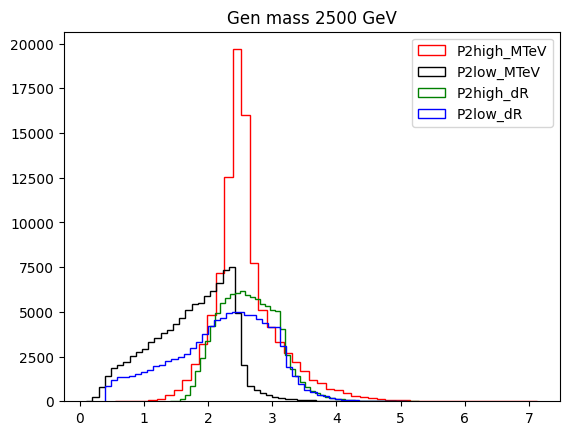

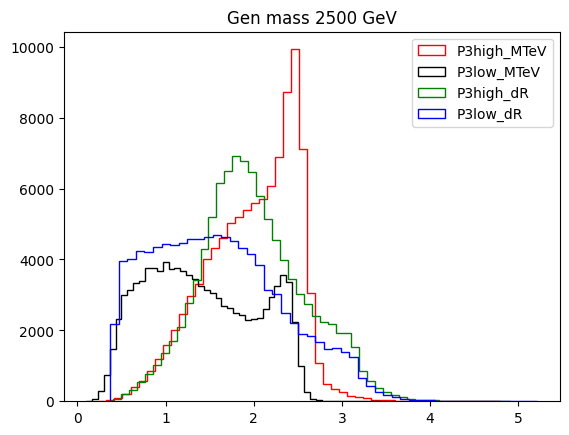

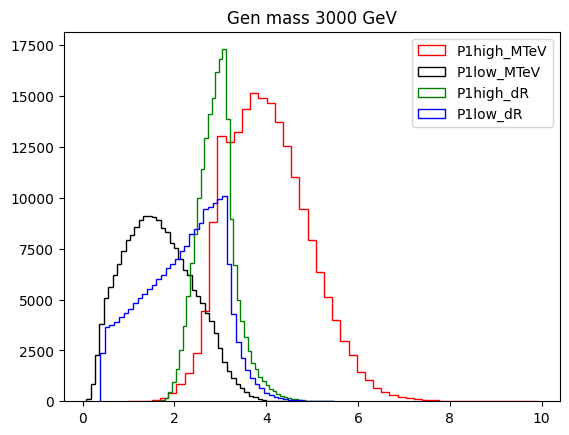

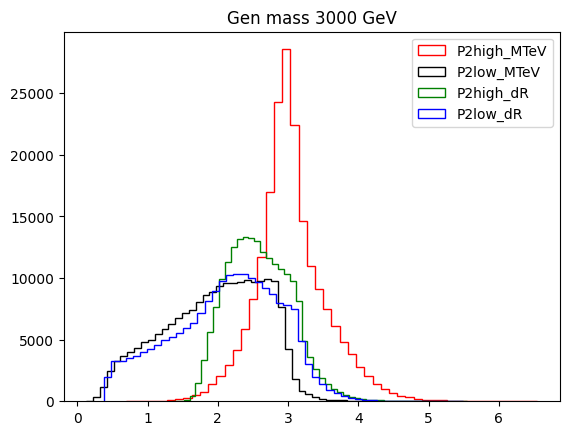

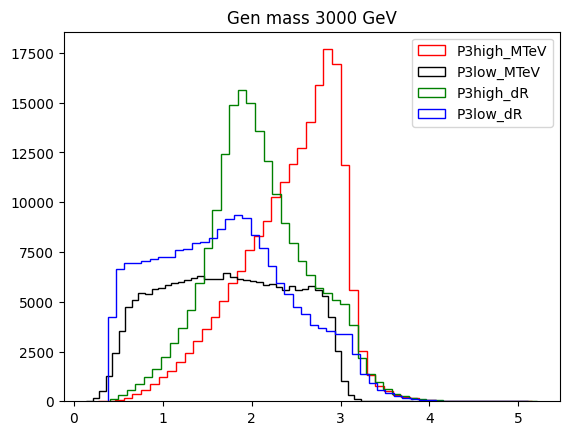

In [14]:
if SanityCheckPlots:
    for Mass in Masses:
        for Pair in ["P1", "P2", "P3"]:
            TrainingDF_temp = TrainingDF.loc[TrainingDF["Mass"] == Mass]
            plt.figure()
            plt.hist(TrainingDF_temp[Pair + "high_MTeV"], bins = 50, histtype = "step", color = "r", label = Pair + "high_MTeV")
            plt.hist(TrainingDF_temp[Pair + "low_MTeV"], bins = 50, histtype = "step", color = "k", label = Pair + "low_MTeV")
            plt.hist(TrainingDF_temp[Pair + "high_dR"], bins = 50, histtype = "step", color = "g", label = Pair + "high_dR")
            plt.hist(TrainingDF_temp[Pair + "low_dR"], bins = 50, histtype = "step", color = "b", label = Pair + "low_dR")
            plt.legend()
            plt.title("Gen mass " + str(Mass) + " GeV")

In [15]:
InputList = ["fourjetmasstev", "P1high_MTeV", "P1low_MTeV", "P1high_dR", "P1low_dR",
             "fourjetmasstev", "P2high_MTeV", "P2low_MTeV", "P2high_dR", "P2low_dR",
             "fourjetmasstev", "P3high_MTeV", "P3low_MTeV", "P3high_dR", "P3low_dR",]


TrainingInputs = TrainingDF[InputList].to_numpy()
TrainingTruth = TrainingDF["Truth_QSMD"].to_numpy()

TestingInputs = TestingDF[InputList].to_numpy()

In [16]:
print(TrainingInputs.shape)
print(TrainingTruth.shape)
print(TestingInputs.shape)

(1744798, 15)
(1744798,)
(900000, 15)


In [17]:
NotebookName = "ResAndNonres_CNN_more"
ResultsDir = "results_temp/results_" + NotebookName + "/"
if not os.path.exists(ResultsDir):
    os.makedirs(ResultsDir)

In [18]:
def model_CNN():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(3*5, ), name="model_in"),
        tf.keras.layers.Reshape((3,5, 1)),
        tf.keras.layers.Conv2D(16, (2,3), activation='relu'),
        tf.keras.layers.Conv2D(8, (2,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax', name="model_out")],
        name = "ModelCNN"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [19]:
def model_CNN_more():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(3*5, ), name="model_in"),
        tf.keras.layers.Reshape((3,5, 1)),
        tf.keras.layers.Conv2D(32, (2,3), activation='relu'),
        tf.keras.layers.Conv2D(16, (2,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax', name="model_out")],
        name = "ModelCNNMore"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [20]:
#Model = model_CNN()
Model = model_CNN_more()

2024-01-28 16:08:25.840529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 16:08:26.441677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11311 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:65:00.0, compute capability: 6.0


In [21]:
Model.summary()

Model: "ModelCNNMore"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 3, 5, 1)           0         
                                                                 
 conv2d (Conv2D)             (None, 2, 3, 32)          224       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 16)          3088      
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 model_out (Dense)           (None, 3)                 27        
                                                                 
Total params: 3,475
Trainable params: 3,475
Non-traina

In [22]:
#import pydot
#import graphviz
#tf.keras.utils.plot_model(Model)

In [23]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(ResultsDir + "Model.h5", save_best_only = True, monitor = "val_loss", mode = "min")

History = Model.fit(TrainingInputs, TrainingTruth, batch_size = 5000,
                    epochs = 100, validation_split = 0.2, callbacks=[checkpoint])

Epoch 1/100


2024-01-28 16:08:28.071330: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


280/280 [==============================] - 4s 6ms/step - loss: 0.7040 - accuracy: 0.6717 - val_loss: 0.5466 - val_accuracy: 0.7562
Epoch 2/100
280/280 [==============================] - 1s 5ms/step - loss: 0.5234 - accuracy: 0.7700 - val_loss: 0.5066 - val_accuracy: 0.7787
Epoch 3/100
280/280 [==============================] - 2s 5ms/step - loss: 0.4980 - accuracy: 0.7823 - val_loss: 0.4914 - val_accuracy: 0.7855
Epoch 4/100
280/280 [==============================] - 1s 5ms/step - loss: 0.4871 - accuracy: 0.7866 - val_loss: 0.4830 - val_accuracy: 0.7877
Epoch 5/100
280/280 [==============================] - 1s 5ms/step - loss: 0.4807 - accuracy: 0.7888 - val_loss: 0.4797 - val_accuracy: 0.7890
Epoch 6/100
280/280 [==============================] - 2s 5ms/step - loss: 0.4767 - accuracy: 0.7903 - val_loss: 0.4756 - val_accuracy: 0.7899
Epoch 7/100
280/280 [==============================] - 1s 5ms/step - loss: 0.4724 - accuracy: 0.7921 - val_loss: 0.4735 - val_accuracy: 0.7906
Epoch 8/100

280/280 [==============================] - 1s 5ms/step - loss: 0.4353 - accuracy: 0.8071 - val_loss: 0.4366 - val_accuracy: 0.8063
Epoch 59/100
280/280 [==============================] - 1s 5ms/step - loss: 0.4353 - accuracy: 0.8071 - val_loss: 0.4418 - val_accuracy: 0.8032
Epoch 60/100
280/280 [==============================] - 1s 5ms/step - loss: 0.4349 - accuracy: 0.8074 - val_loss: 0.4360 - val_accuracy: 0.8068
Epoch 61/100
280/280 [==============================] - 1s 5ms/step - loss: 0.4348 - accuracy: 0.8076 - val_loss: 0.4345 - val_accuracy: 0.8073
Epoch 62/100
280/280 [==============================] - 1s 5ms/step - loss: 0.4344 - accuracy: 0.8077 - val_loss: 0.4362 - val_accuracy: 0.8070
Epoch 63/100
280/280 [==============================] - 1s 5ms/step - loss: 0.4346 - accuracy: 0.8075 - val_loss: 0.4354 - val_accuracy: 0.8067
Epoch 64/100
280/280 [==============================] - 1s 5ms/step - loss: 0.4341 - accuracy: 0.8077 - val_loss: 0.4354 - val_accuracy: 0.8068
Epoch

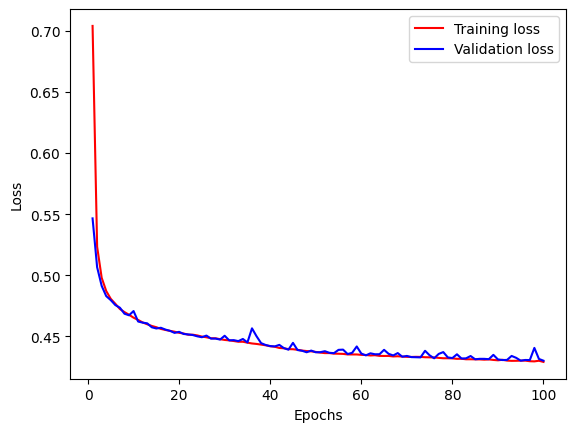

In [24]:
Loss = History.history["loss"]
ValLoss = History.history["val_loss"]
Epochs = range(1, len(Loss) + 1)

plt.plot(Epochs, Loss, "r", label="Training loss")
plt.plot(Epochs, ValLoss, "b", label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
    
plt.savefig(ResultsDir + "Loss_vs_Epochs.png")

In [25]:
#Model.save(ResultsDir + "Model.h5")

ModelTest = tf.keras.models.load_model(ResultsDir + "Model.h5")
TestingOutputs = ModelTest.predict(TestingInputs, batch_size = 5000)

180/180 [==============================] - 0s 2ms/step


In [26]:
TestingOutputs[0] #ML raw output is the probability of 3 sparse categories

array([0.00298444, 0.8655441 , 0.13147157], dtype=float32)

In [27]:
TestingPredictions = np.argmax(TestingOutputs, axis = 1) #pick the highest probability as ML output

In [28]:
print(TestingPredictions.shape)
print(TestingPredictions[0])

(900000,)
1


In [29]:
TestingDF["Pred"] = TestingPredictions.tolist()

In [30]:
TestingDF

Mass  evt_trig  fourjetmasstev  Mjj_avg_dRpairing_GeV  P1high_MTeV  \
0        500         1        1.665246             569.138611     1.083193   
1        500         1        1.109070             235.760468     0.703446   
2        500         1        1.522245             473.871796     0.884906   
3        500         1        2.525532             472.603851     2.169740   
4        500         1        1.569428             567.971130     0.936199   
...      ...       ...             ...                    ...          ...   
899995  3000         1        6.350856            1795.730347     4.804782   
899996  3000         1        7.045433            2193.599121     4.114034   
899997  3000         1        6.106929            2073.016602     3.912739   
899998  3000         1        6.691267            2029.300537     4.402146   
899999  3000         1        5.453666            1839.936157     2.826984   

        P1low_MTeV  P2high_MTeV  P2low_MTeV  P3high_MTeV  P3low_MTeV  \
0         0.373950     0.676399    0.612059     0.610390    0.527888   
1         0.375377     0.497867    0.468088     0.342566    0.128955   
2         0.596236     0.743461    0.438657     0.513220    0.434524   
3         0.265412     0.801181    0.651792     0.703891    0.241316   
4         0.199743     0.899177    0.482994     0.512215    0.500105   
...            ...          ...         ...          ...         ...   
899995    0.370098     2.818387    1.679034     1.898205    1.693256   
899996    2.485709     3.623191    1.723898     2.964133    1.423066   
899997    0.992608     2.851816    1.294218     2.404592    2.350684   
899998    2.200221     2.549594    2.480623     2.059506    1.999095   
899999    2.120573     2.797577    1.243979     2.628401    1.051471   

        P1high_dR  P1low_dR  P2high_dR  P2low_dR  P3high_dR  P3low_dR  \
0        2.782113  1.547665   1.907177  2.159548   2.022496  1.730264   
1        3.113047  2.368026   2.692501  1.955640   1.254488  0.457324   
2        3.090241  3.215255   2.348969  1.981968   1.479761  1.521776   
3        2.993525  2.251249   2.862716  2.342220   1.928741  0.635207   
4        2.279822  0.934763   2.700373  2.369658   1.880583  1.437924   
...           ...       ...        ...       ...        ...       ...   
899995   3.079867  0.589019   2.524088  1.910917   1.364884  2.403678   
899996   2.577298  3.281451   2.339519  1.714503   2.007617  0.997858   
899997   2.651374  1.257954   2.106477  1.373415   2.930459  2.127089   
899998   2.858452  3.731218   3.120820  2.385565   1.784458  1.811392   
899999   2.256274  3.220705   2.153904  1.325719   1.925846  1.116771   

           P1high_M      P1low_M     P2high_M      P2low_M     P3high_M  \
0       1083.193410   373.949755   676.398680   612.058930   610.389668   
1        703.445644   375.376717   497.867207   468.088484   342.566192   
2        884.905691   596.236004   743.460797   438.656782   513.219915   
3       2169.740485   265.412339   801.180826   651.791965   703.891486   
4        936.198882   199.743343   899.176959   482.993652   512.215294   
...             ...          ...          ...          ...          ...   
899995  4804.781804   370.097505  2818.387329  1679.033672  1898.204977   
899996  4114.033672  2485.709315  3623.191112  1723.897678  2964.132740   
899997  3912.738794   992.607866  2851.815519  1294.217623  2404.592353   
899998  4402.146485  2200.220719  2549.593769  2480.622685  2059.506019   
899999  2826.983823  2120.572601  2797.577222  1243.978863  2628.400983   

            P3low_M          P1M          P2M          P3M  dRi  Truth_high  \
0        527.887546   728.571582   644.228805   569.138607    2           2   
1        128.954730   539.411181   482.977846   235.760461    2           1   
2        434.523672   740.570848   591.058789   473.871794    2           2   
3        241.316244  1217.576412   726.486396   472.603865    2           2   
4        500.104844   567.971112 

In [31]:
AccPred = []
AccdR = []
Acc0 = []
Acc1 = []
Acc2 = []
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    TestingDF_pred = TestingDF_temp.loc[TestingDF_temp["Pred"]==TestingDF_temp["Truth_QSMD"]]
    TestingDF_dR = TestingDF_temp.loc[TestingDF_temp["dRi"]==TestingDF_temp["Truth_QSMD"]]
    TestingDF_0 = TestingDF_temp.loc[0==TestingDF_temp["Truth_QSMD"]]
    TestingDF_1 = TestingDF_temp.loc[1==TestingDF_temp["Truth_QSMD"]]
    TestingDF_2 = TestingDF_temp.loc[2==TestingDF_temp["Truth_QSMD"]]

    AccPred.append(float(len(TestingDF_pred.index))/len(TestingDF_temp.index))
    AccdR.append(float(len(TestingDF_dR.index))/len(TestingDF_temp.index))
    Acc0.append(float(len(TestingDF_0.index))/len(TestingDF_temp.index))
    Acc1.append(float(len(TestingDF_1.index))/len(TestingDF_temp.index))
    Acc2.append(float(len(TestingDF_2.index))/len(TestingDF_temp.index))

In [32]:
AccPredAvg = "Avg %.2f" % float(sum(AccPred)/len(AccPred))
AccdRAvg = "Avg %.2f" % float(sum(AccdR)/len(AccdR))
Acc0Avg = "Avg %.2f" % float(sum(Acc0)/len(Acc0))
Acc1Avg = "Avg %.2f" % float(sum(Acc1)/len(Acc1))
Acc2Avg = "Avg %.2f" % float(sum(Acc2)/len(Acc2))

print(", ".join(["%.2f" % i for i in AccPred]), AccPredAvg)
print(", ".join(["%.2f" % i for i in AccdR]), AccdRAvg)
print(", ".join(["%.2f" % i for i in Acc0]), Acc0Avg)
print(", ".join(["%.2f" % i for i in Acc1]), Acc1Avg)
print(", ".join(["%.2f" % i for i in Acc2]), Acc2Avg)

0.73, 0.79, 0.79, 0.78, 0.79, 0.78, 0.78, 0.80, 0.83, 0.81, 0.86, 0.91, 0.84, 0.85 Avg 0.81
0.56, 0.26, 0.20, 0.18, 0.16, 0.41, 0.12, 0.11, 0.60, 0.11, 0.37, 0.56, 0.10, 0.08 Avg 0.27
0.02, 0.10, 0.14, 0.16, 0.16, 0.09, 0.19, 0.20, 0.01, 0.19, 0.11, 0.04, 0.17, 0.14 Avg 0.12
0.23, 0.41, 0.44, 0.45, 0.47, 0.33, 0.50, 0.51, 0.25, 0.51, 0.36, 0.24, 0.51, 0.51 Avg 0.41
0.75, 0.49, 0.43, 0.39, 0.37, 0.58, 0.32, 0.30, 0.73, 0.29, 0.54, 0.72, 0.32, 0.35 Avg 0.47


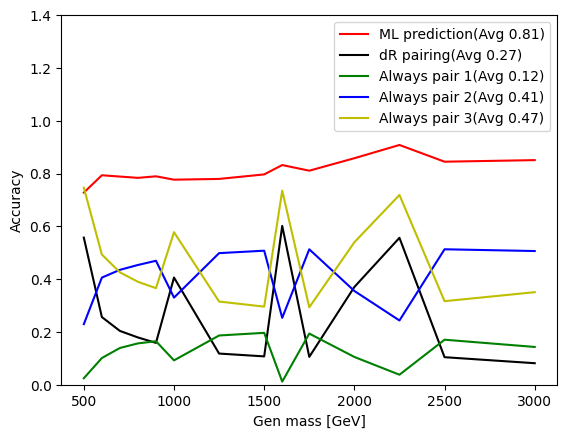

In [33]:
plt.plot(Masses, AccPred, "r", label = "ML prediction(" + AccPredAvg + ")")
plt.plot(Masses, AccdR, "k", label = "dR pairing(" + AccdRAvg + ")")
plt.plot(Masses, Acc0, "g", label = "Always pair 1(" + Acc0Avg + ")")
plt.plot(Masses, Acc1, "b", label = "Always pair 2(" + Acc1Avg + ")")
plt.plot(Masses, Acc2, "y", label = "Always pair 3(" + Acc2Avg + ")")
plt.legend()
plt.xlabel("Gen mass [GeV]")
plt.ylabel("Accuracy")
plt.ylim(0, 1.4)
plt.savefig(ResultsDir + "Accuracy_vs_mass.png")

In [34]:
P1Mi = TestingDF.columns.get_loc("P1M")
#TestingDF["dR_M"] = TestingDF.apply(lambda row: row.iloc[row["dRi"]], axis=1)
TestingDF["dR_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["dRi"]]
TestingDF["Truth_high_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Truth_high"]]
TestingDF["Truth_avg_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Truth_avg"]]
TestingDF["Pred_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Pred"]]
TestingDF

Mass  evt_trig  fourjetmasstev  Mjj_avg_dRpairing_GeV  P1high_MTeV  \
0        500         1        1.665246             569.138611     1.083193   
1        500         1        1.109070             235.760468     0.703446   
2        500         1        1.522245             473.871796     0.884906   
3        500         1        2.525532             472.603851     2.169740   
4        500         1        1.569428             567.971130     0.936199   
...      ...       ...             ...                    ...          ...   
899995  3000         1        6.350856            1795.730347     4.804782   
899996  3000         1        7.045433            2193.599121     4.114034   
899997  3000         1        6.106929            2073.016602     3.912739   
899998  3000         1        6.691267            2029.300537     4.402146   
899999  3000         1        5.453666            1839.936157     2.826984   

        P1low_MTeV  P2high_MTeV  P2low_MTeV  P3high_MTeV  P3low_MTeV  \
0         0.373950     0.676399    0.612059     0.610390    0.527888   
1         0.375377     0.497867    0.468088     0.342566    0.128955   
2         0.596236     0.743461    0.438657     0.513220    0.434524   
3         0.265412     0.801181    0.651792     0.703891    0.241316   
4         0.199743     0.899177    0.482994     0.512215    0.500105   
...            ...          ...         ...          ...         ...   
899995    0.370098     2.818387    1.679034     1.898205    1.693256   
899996    2.485709     3.623191    1.723898     2.964133    1.423066   
899997    0.992608     2.851816    1.294218     2.404592    2.350684   
899998    2.200221     2.549594    2.480623     2.059506    1.999095   
899999    2.120573     2.797577    1.243979     2.628401    1.051471   

        P1high_dR  P1low_dR  P2high_dR  P2low_dR  P3high_dR  P3low_dR  \
0        2.782113  1.547665   1.907177  2.159548   2.022496  1.730264   
1        3.113047  2.368026   2.692501  1.955640   1.254488  0.457324   
2        3.090241  3.215255   2.348969  1.981968   1.479761  1.521776   
3        2.993525  2.251249   2.862716  2.342220   1.928741  0.635207   
4        2.279822  0.934763   2.700373  2.369658   1.880583  1.437924   
...           ...       ...        ...       ...        ...       ...   
899995   3.079867  0.589019   2.524088  1.910917   1.364884  2.403678   
899996   2.577298  3.281451   2.339519  1.714503   2.007617  0.997858   
899997   2.651374  1.257954   2.106477  1.373415   2.930459  2.127089   
899998   2.858452  3.731218   3.120820  2.385565   1.784458  1.811392   
899999   2.256274  3.220705   2.153904  1.325719   1.925846  1.116771   

           P1high_M      P1low_M     P2high_M      P2low_M     P3high_M  \
0       1083.193410   373.949755   676.398680   612.058930   610.389668   
1        703.445644   375.376717   497.867207   468.088484   342.566192   
2        884.905691   596.236004   743.460797   438.656782   513.219915   
3       2169.740485   265.412339   801.180826   651.791965   703.891486   
4        936.198882   199.743343   899.176959   482.993652   512.215294   
...             ...          ...          ...          ...          ...   
899995  4804.781804   370.097505  2818.387329  1679.033672  1898.204977   
899996  4114.033672  2485.709315  3623.191112  1723.897678  2964.132740   
899997  3912.738794   992.607866  2851.815519  1294.217623  2404.592353   
899998  4402.146485  2200.220719  2549.593769  2480.622685  2059.506019   
899999  2826.983823  2120.572601  2797.577222  1243.978863  2628.400983   

            P3low_M          P1M          P2M          P3M  dRi  Truth_high  \
0        527.887546   728.571582   644.228805   569.138607    2           2   
1        128.954730   539.411181   482.977846   235.760461    2           1   
2        434.523672   740.570848   591.058789   473.871794    2           2   
3        241.316244  1217.576412   726.486396   472.603865    2           2   
4        500.104844   567.971112 

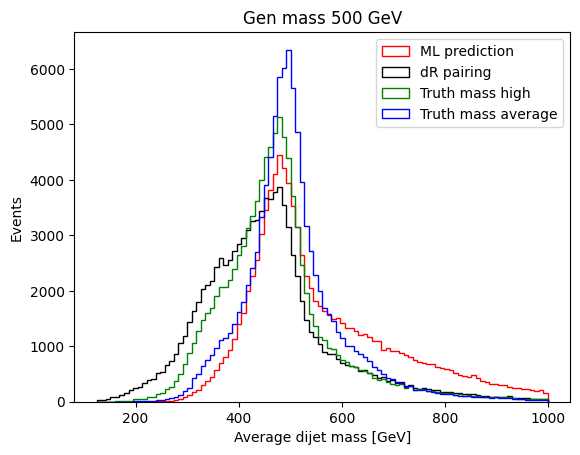

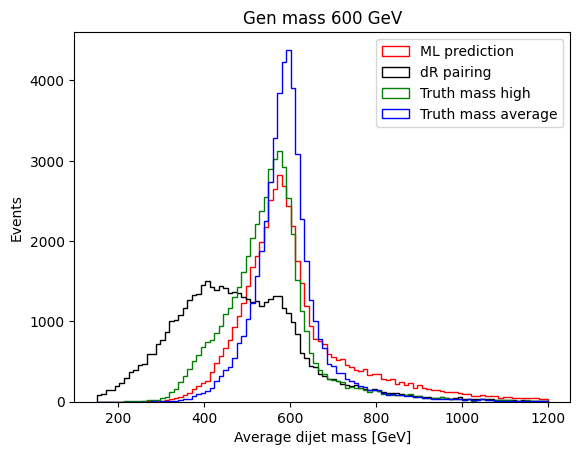

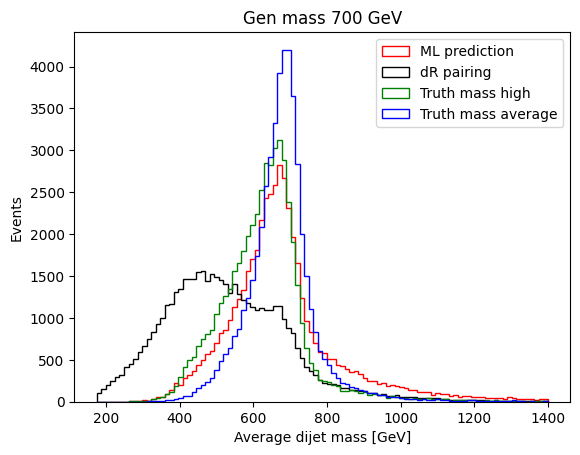

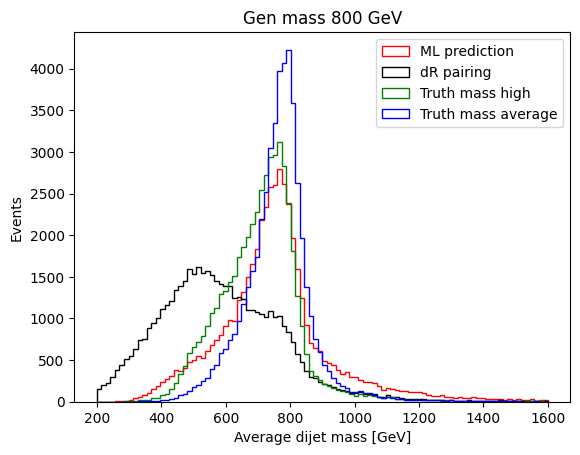

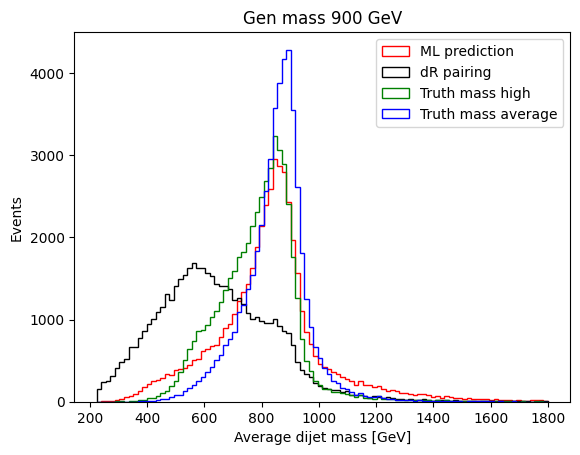

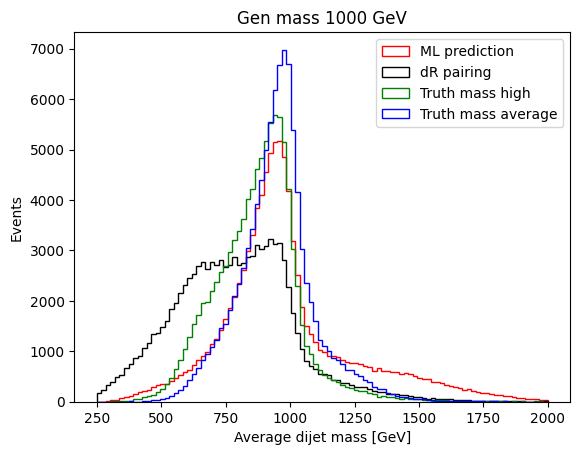

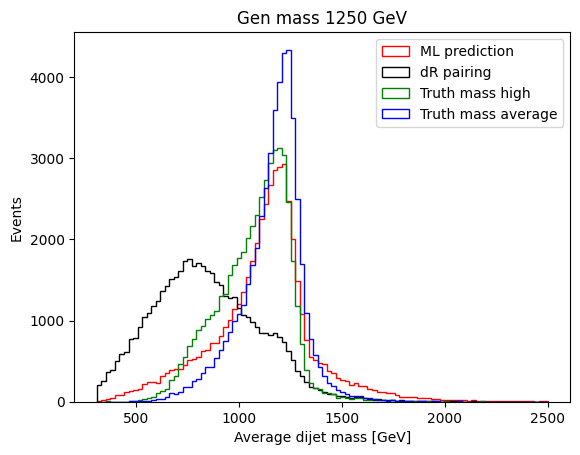

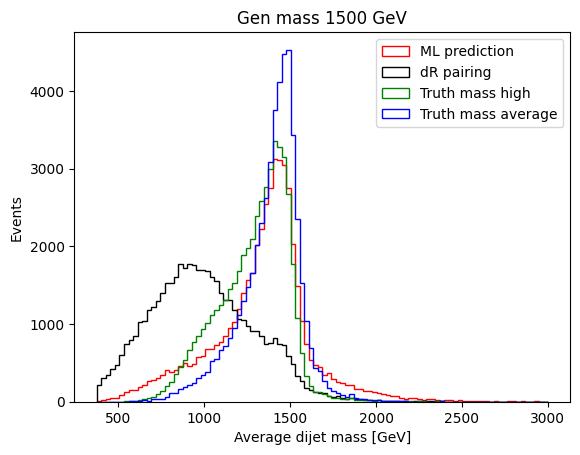

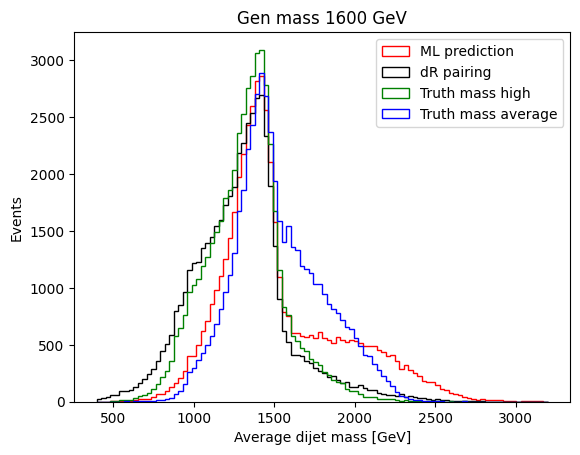

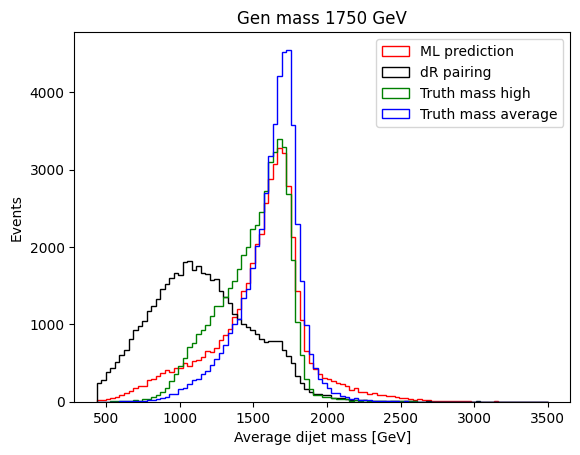

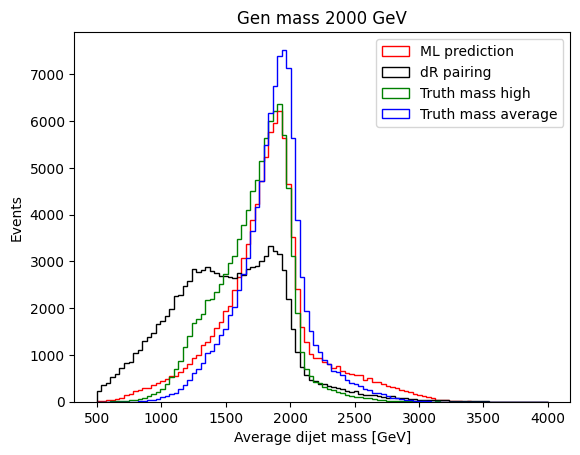

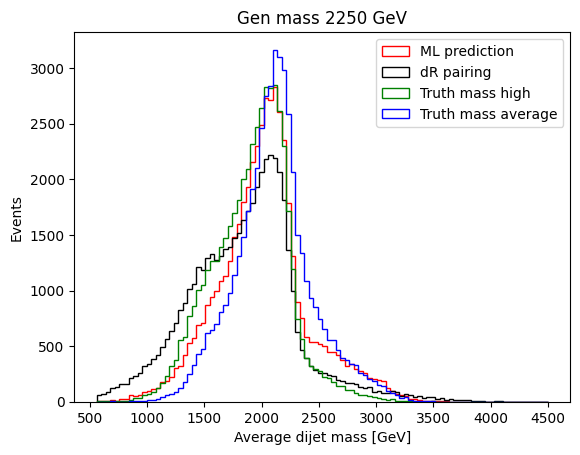

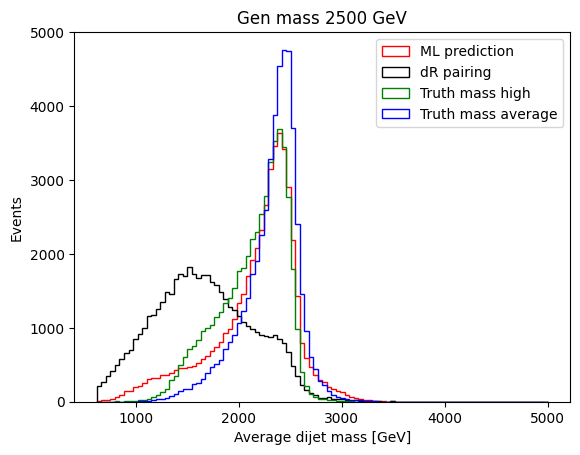

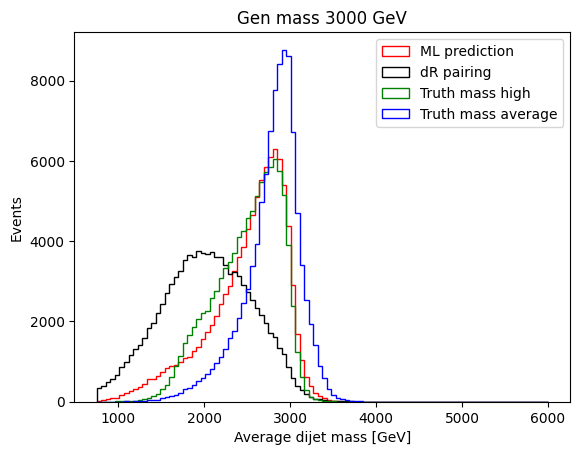

In [35]:
# for each gen mass sample, plot average dijet mass
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_M"], bins = 100, range = [Mass/4, Mass*2], histtype = "step",
             color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_M"], bins = 100, range = [Mass/4, Mass*2], histtype = "step",
             color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_M"], bins = 100, range = [Mass/4, Mass*2], histtype = "step",
             color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_M"], bins = 100, range = [Mass/4, Mass*2], histtype = "step",
             color = "b", label = "Truth mass average")
    plt.legend()
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("Average dijet mass [GeV]")
    plt.ylabel("Events")
    plt.savefig(ResultsDir + "Average_dijet_mass_" + str(Mass) + "GeV.png")

In [36]:
P1M_high_i = TestingDF.columns.get_loc("P1high_M")
TestingDF["dR_M_high"] = TestingDF.to_numpy()[
    np.arange(len(TestingDF)), P1M_high_i + TestingDF["dRi"]*2]
TestingDF["Truth_high_M_high"] = TestingDF.to_numpy()[
    np.arange(len(TestingDF)), P1M_high_i + TestingDF["Truth_high"]*2]
TestingDF["Truth_avg_M_high"] = TestingDF.to_numpy()[
    np.arange(len(TestingDF)), P1M_high_i + TestingDF["Truth_avg"]*2]
TestingDF["Pred_M_high"] = TestingDF.to_numpy()[
    np.arange(len(TestingDF)), P1M_high_i + TestingDF["Pred"]*2]
TestingDF

Mass  evt_trig  fourjetmasstev  Mjj_avg_dRpairing_GeV  P1high_MTeV  \
0        500         1        1.665246             569.138611     1.083193   
1        500         1        1.109070             235.760468     0.703446   
2        500         1        1.522245             473.871796     0.884906   
3        500         1        2.525532             472.603851     2.169740   
4        500         1        1.569428             567.971130     0.936199   
...      ...       ...             ...                    ...          ...   
899995  3000         1        6.350856            1795.730347     4.804782   
899996  3000         1        7.045433            2193.599121     4.114034   
899997  3000         1        6.106929            2073.016602     3.912739   
899998  3000         1        6.691267            2029.300537     4.402146   
899999  3000         1        5.453666            1839.936157     2.826984   

        P1low_MTeV  P2high_MTeV  P2low_MTeV  P3high_MTeV  P3low_MTeV  \
0         0.373950     0.676399    0.612059     0.610390    0.527888   
1         0.375377     0.497867    0.468088     0.342566    0.128955   
2         0.596236     0.743461    0.438657     0.513220    0.434524   
3         0.265412     0.801181    0.651792     0.703891    0.241316   
4         0.199743     0.899177    0.482994     0.512215    0.500105   
...            ...          ...         ...          ...         ...   
899995    0.370098     2.818387    1.679034     1.898205    1.693256   
899996    2.485709     3.623191    1.723898     2.964133    1.423066   
899997    0.992608     2.851816    1.294218     2.404592    2.350684   
899998    2.200221     2.549594    2.480623     2.059506    1.999095   
899999    2.120573     2.797577    1.243979     2.628401    1.051471   

        P1high_dR  P1low_dR  P2high_dR  P2low_dR  P3high_dR  P3low_dR  \
0        2.782113  1.547665   1.907177  2.159548   2.022496  1.730264   
1        3.113047  2.368026   2.692501  1.955640   1.254488  0.457324   
2        3.090241  3.215255   2.348969  1.981968   1.479761  1.521776   
3        2.993525  2.251249   2.862716  2.342220   1.928741  0.635207   
4        2.279822  0.934763   2.700373  2.369658   1.880583  1.437924   
...           ...       ...        ...       ...        ...       ...   
899995   3.079867  0.589019   2.524088  1.910917   1.364884  2.403678   
899996   2.577298  3.281451   2.339519  1.714503   2.007617  0.997858   
899997   2.651374  1.257954   2.106477  1.373415   2.930459  2.127089   
899998   2.858452  3.731218   3.120820  2.385565   1.784458  1.811392   
899999   2.256274  3.220705   2.153904  1.325719   1.925846  1.116771   

           P1high_M      P1low_M     P2high_M      P2low_M     P3high_M  \
0       1083.193410   373.949755   676.398680   612.058930   610.389668   
1        703.445644   375.376717   497.867207   468.088484   342.566192   
2        884.905691   596.236004   743.460797   438.656782   513.219915   
3       2169.740485   265.412339   801.180826   651.791965   703.891486   
4        936.198882   199.743343   899.176959   482.993652   512.215294   
...             ...          ...          ...          ...          ...   
899995  4804.781804   370.097505  2818.387329  1679.033672  1898.204977   
899996  4114.033672  2485.709315  3623.191112  1723.897678  2964.132740   
899997  3912.738794   992.607866  2851.815519  1294.217623  2404.592353   
899998  4402.146485  2200.220719  2549.593769  2480.622685  2059.506019   
899999  2826.983823  2120.572601  2797.577222  1243.978863  2628.400983   

            P3low_M          P1M          P2M          P3M  dRi  Truth_high  \
0        527.887546   728.571582   644.228805   569.138607    2           2   
1        128.954730   539.411181   482.977846   235.760461    2           1   
2        434.523672   740.570848   591.058789   473.871794    2           2   
3        241.316244  1217.576412   726.486396   472.603865    2           2   
4        500.104844   567.971112 

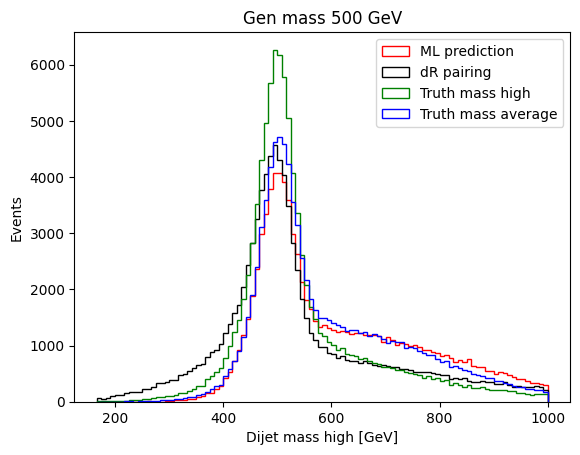

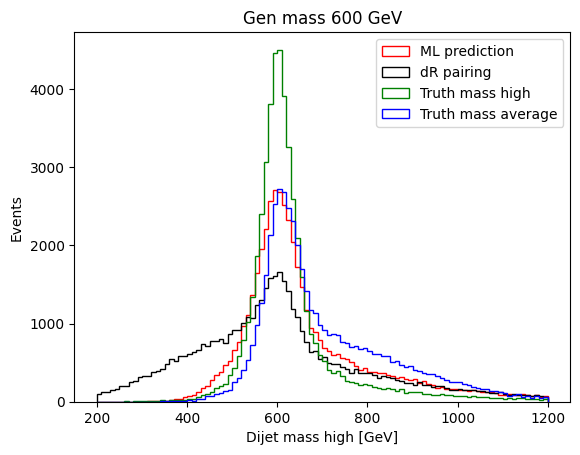

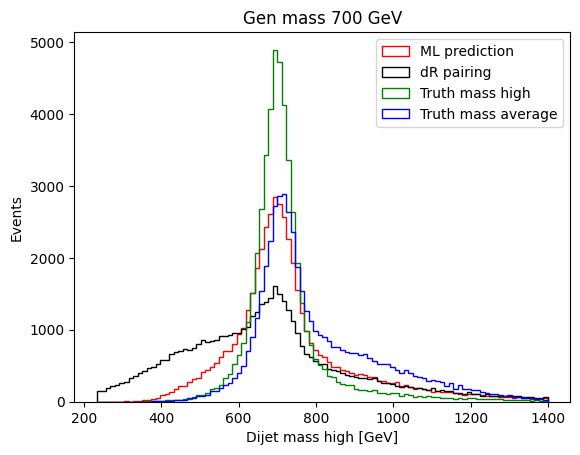

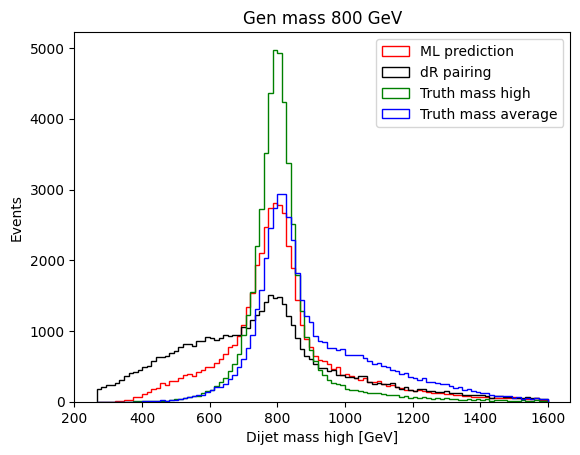

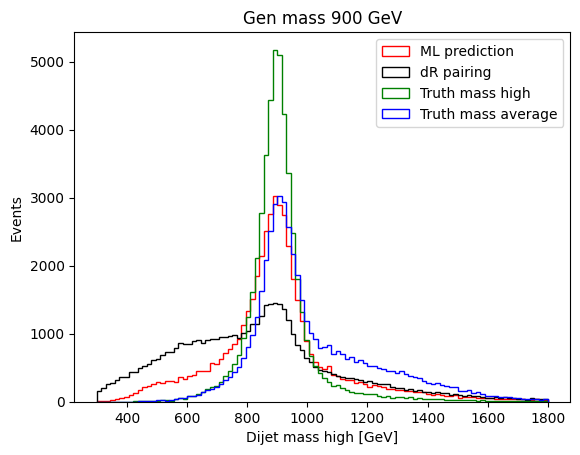

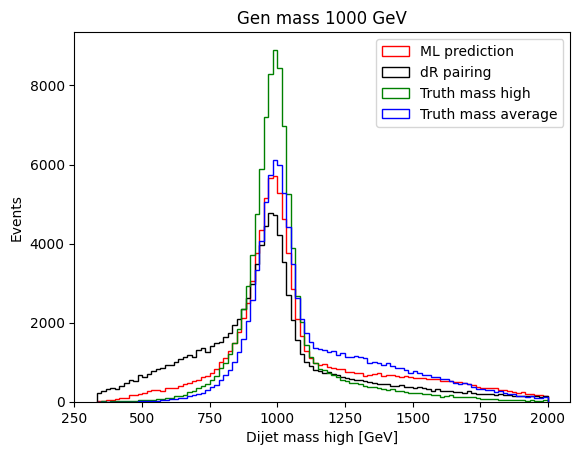

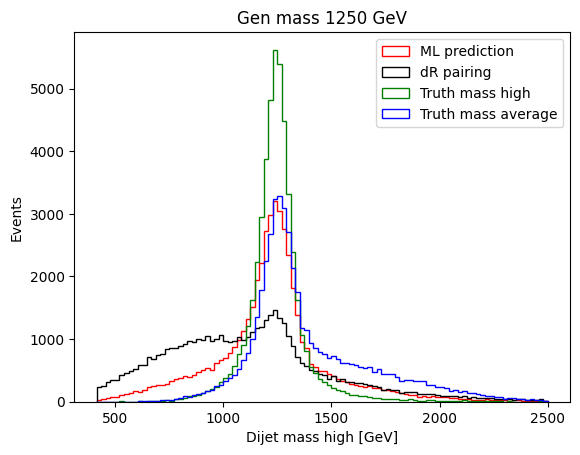

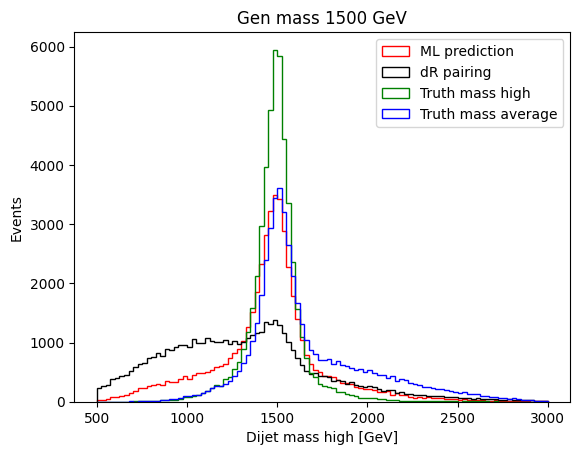

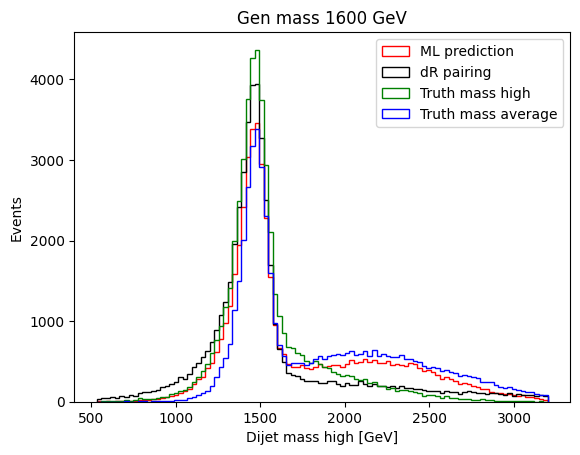

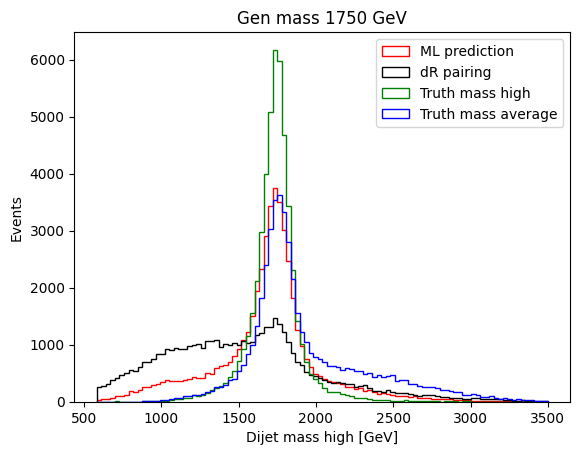

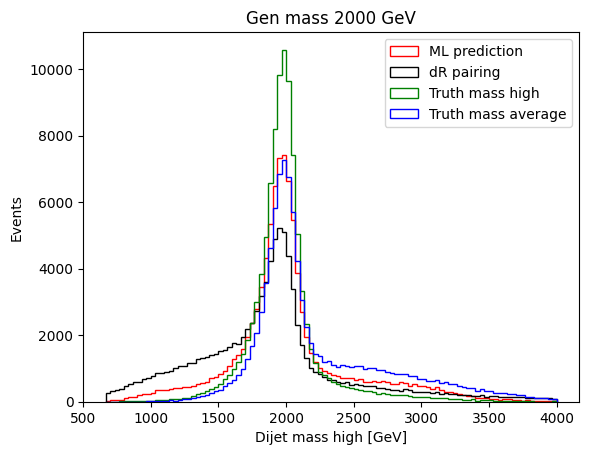

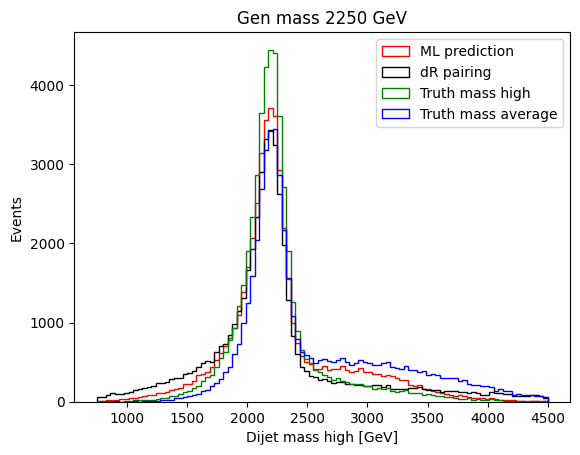

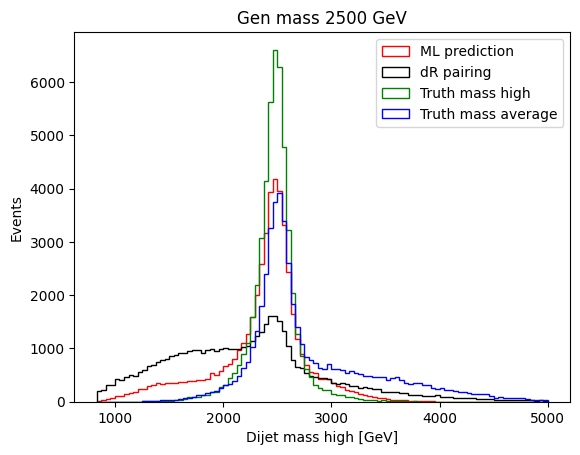

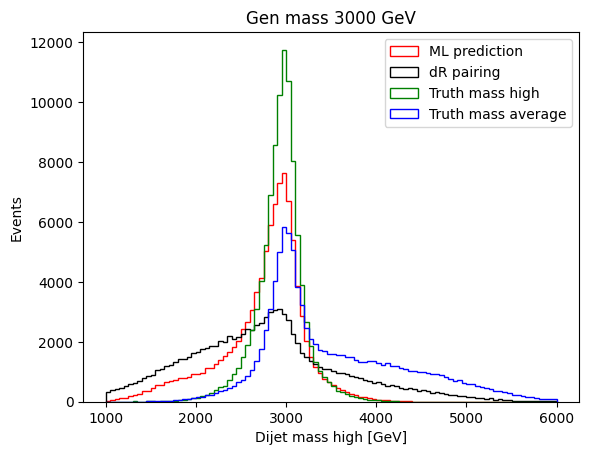

In [37]:
# for each gen mass sample, plot dijet mass high
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_M_high"], bins = 100, range = [Mass/3, Mass*2],
             histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_M_high"], bins = 100, range = [Mass/3, Mass*2],
             histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_M_high"], bins = 100, range = [Mass/3, Mass*2],
             histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_M_high"], bins = 100, range = [Mass/3, Mass*2],
             histtype = "step", color = "b", label = "Truth mass average")
    plt.legend(loc="upper right")
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("Dijet mass high [GeV]")
    plt.ylabel("Events")
    plt.savefig(ResultsDir + "Dijet_mass_high_" + str(Mass) + "GeV.png")

In [38]:
P1QSMDi = TestingDF.columns.get_loc("P1QSMD")
TestingDF["dR_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["dRi"]]
TestingDF["Truth_high_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Truth_high"]]
TestingDF["Truth_avg_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Truth_avg"]]
TestingDF["Pred_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Pred"]]
TestingDF

Mass  evt_trig  fourjetmasstev  Mjj_avg_dRpairing_GeV  P1high_MTeV  \
0        500         1        1.665246             569.138611     1.083193   
1        500         1        1.109070             235.760468     0.703446   
2        500         1        1.522245             473.871796     0.884906   
3        500         1        2.525532             472.603851     2.169740   
4        500         1        1.569428             567.971130     0.936199   
...      ...       ...             ...                    ...          ...   
899995  3000         1        6.350856            1795.730347     4.804782   
899996  3000         1        7.045433            2193.599121     4.114034   
899997  3000         1        6.106929            2073.016602     3.912739   
899998  3000         1        6.691267            2029.300537     4.402146   
899999  3000         1        5.453666            1839.936157     2.826984   

        P1low_MTeV  P2high_MTeV  P2low_MTeV  P3high_MTeV  P3low_MTeV  \
0         0.373950     0.676399    0.612059     0.610390    0.527888   
1         0.375377     0.497867    0.468088     0.342566    0.128955   
2         0.596236     0.743461    0.438657     0.513220    0.434524   
3         0.265412     0.801181    0.651792     0.703891    0.241316   
4         0.199743     0.899177    0.482994     0.512215    0.500105   
...            ...          ...         ...          ...         ...   
899995    0.370098     2.818387    1.679034     1.898205    1.693256   
899996    2.485709     3.623191    1.723898     2.964133    1.423066   
899997    0.992608     2.851816    1.294218     2.404592    2.350684   
899998    2.200221     2.549594    2.480623     2.059506    1.999095   
899999    2.120573     2.797577    1.243979     2.628401    1.051471   

        P1high_dR  P1low_dR  P2high_dR  P2low_dR  P3high_dR  P3low_dR  \
0        2.782113  1.547665   1.907177  2.159548   2.022496  1.730264   
1        3.113047  2.368026   2.692501  1.955640   1.254488  0.457324   
2        3.090241  3.215255   2.348969  1.981968   1.479761  1.521776   
3        2.993525  2.251249   2.862716  2.342220   1.928741  0.635207   
4        2.279822  0.934763   2.700373  2.369658   1.880583  1.437924   
...           ...       ...        ...       ...        ...       ...   
899995   3.079867  0.589019   2.524088  1.910917   1.364884  2.403678   
899996   2.577298  3.281451   2.339519  1.714503   2.007617  0.997858   
899997   2.651374  1.257954   2.106477  1.373415   2.930459  2.127089   
899998   2.858452  3.731218   3.120820  2.385565   1.784458  1.811392   
899999   2.256274  3.220705   2.153904  1.325719   1.925846  1.116771   

           P1high_M      P1low_M     P2high_M      P2low_M     P3high_M  \
0       1083.193410   373.949755   676.398680   612.058930   610.389668   
1        703.445644   375.376717   497.867207   468.088484   342.566192   
2        884.905691   596.236004   743.460797   438.656782   513.219915   
3       2169.740485   265.412339   801.180826   651.791965   703.891486   
4        936.198882   199.743343   899.176959   482.993652   512.215294   
...             ...          ...          ...          ...          ...   
899995  4804.781804   370.097505  2818.387329  1679.033672  1898.204977   
899996  4114.033672  2485.709315  3623.191112  1723.897678  2964.132740   
899997  3912.738794   992.607866  2851.815519  1294.217623  2404.592353   
899998  4402.146485  2200.220719  2549.593769  2480.622685  2059.506019   
899999  2826.983823  2120.572601  2797.577222  1243.978863  2628.400983   

            P3low_M          P1M          P2M          P3M  dRi  Truth_high  \
0        527.887546   728.571582   644.228805   569.138607    2           2   
1        128.954730   539.411181   482.977846   235.760461    2           1   
2        434.523672   740.570848   591.058789   473.871794    2           2   
3        241.316244  1217.576412   726.486396   472.603865    2           2   
4        500.104844   567.971112 

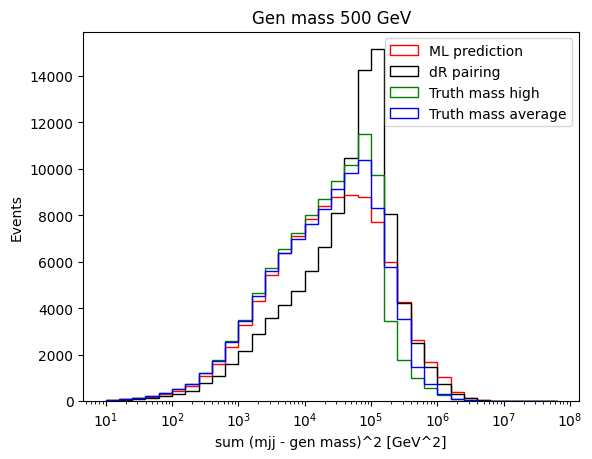

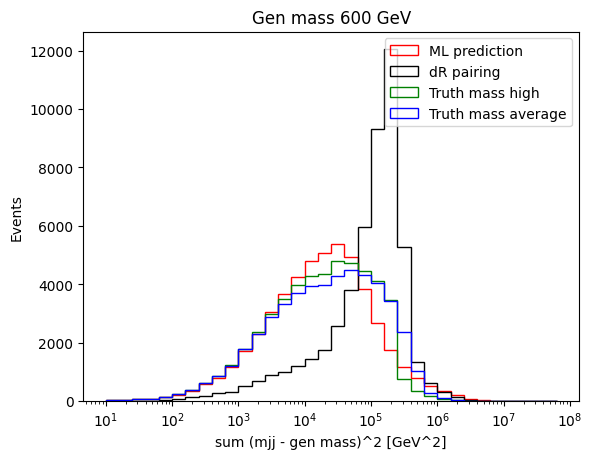

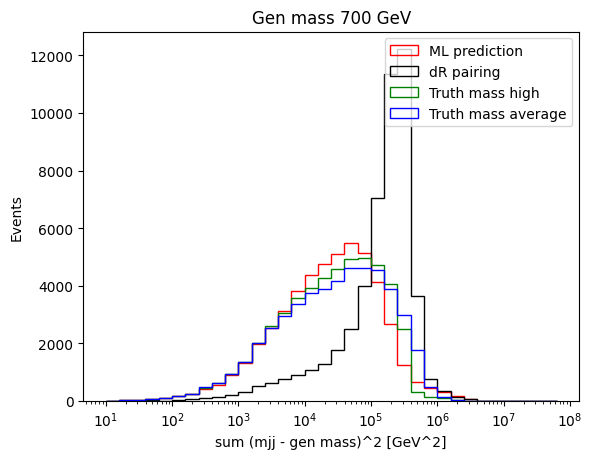

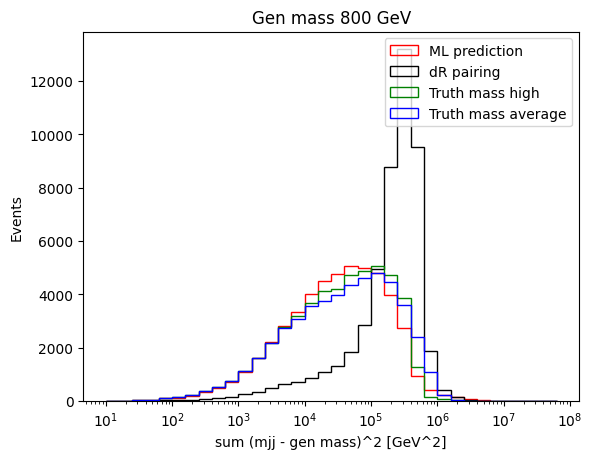

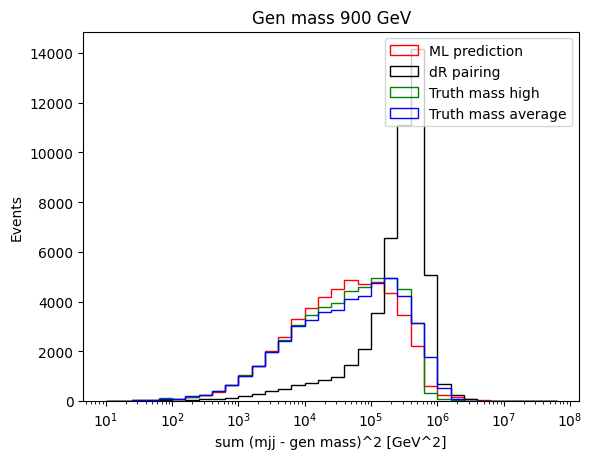

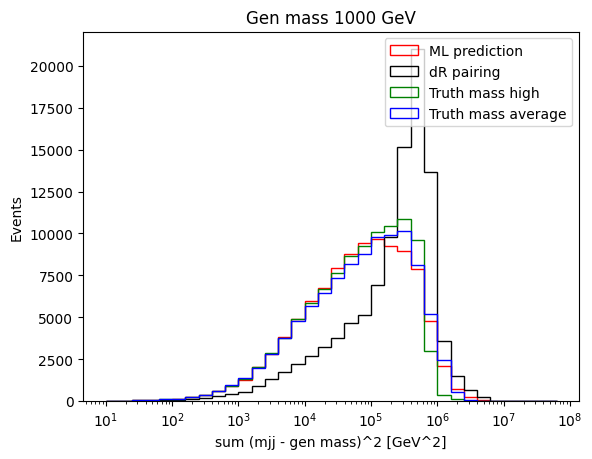

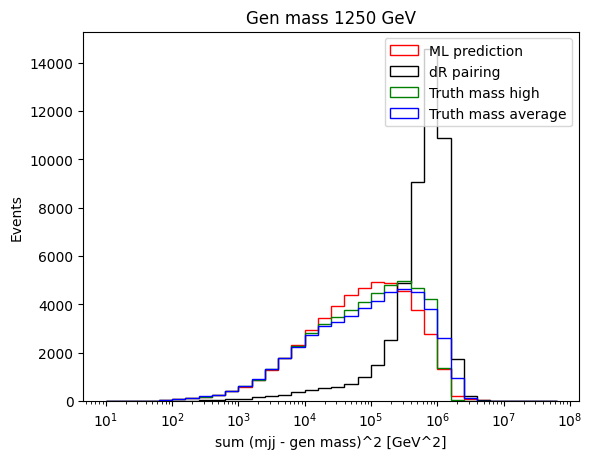

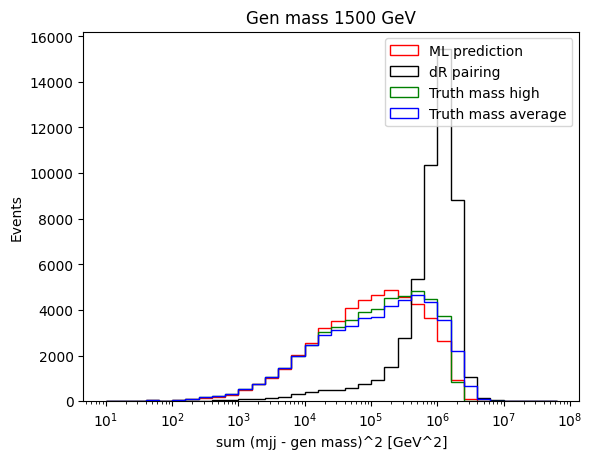

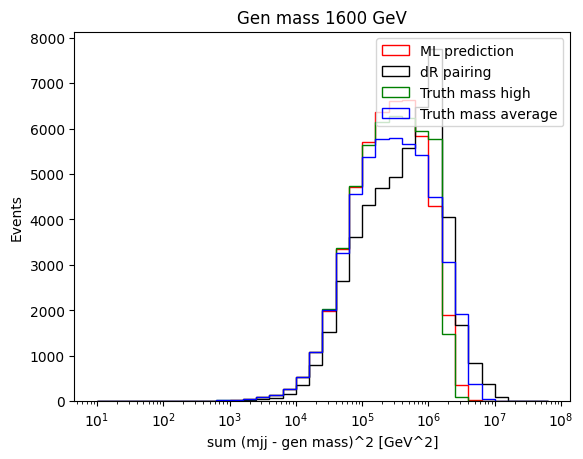

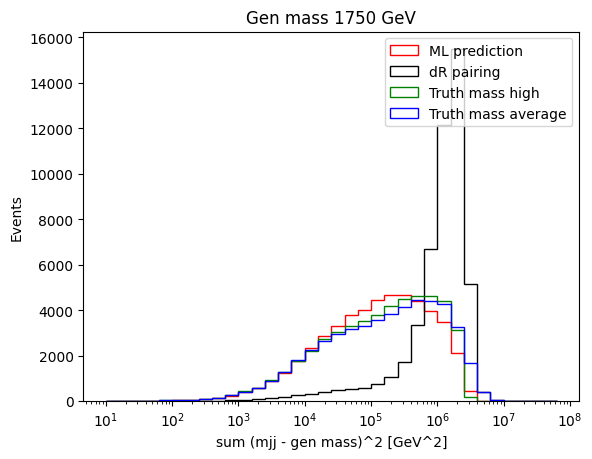

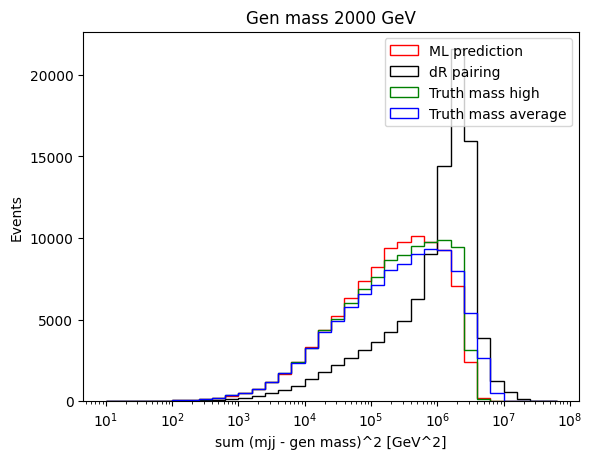

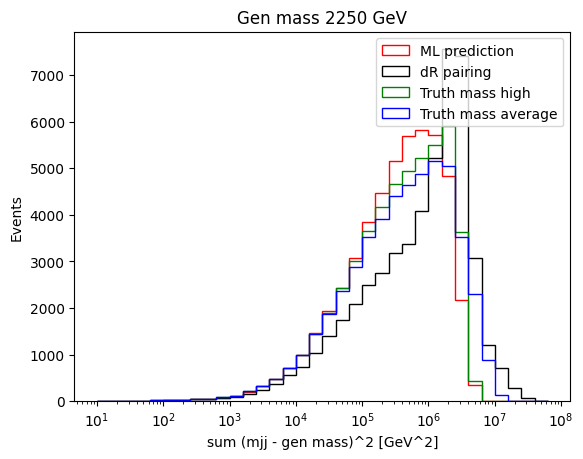

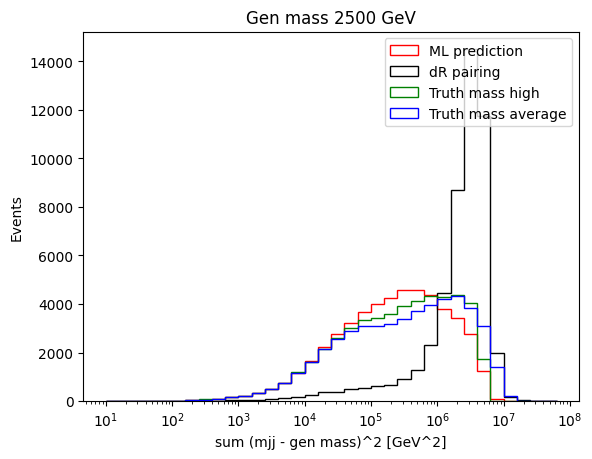

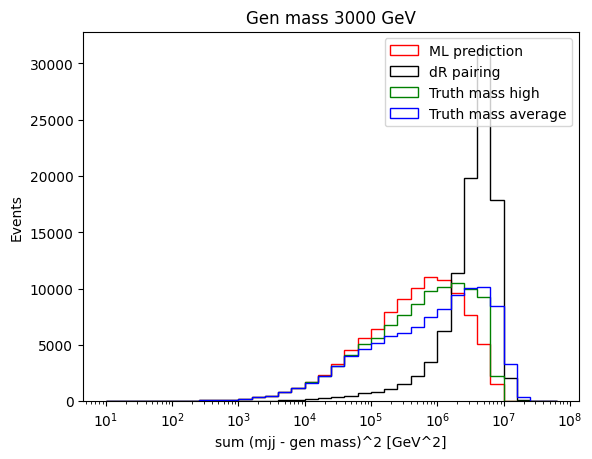

In [39]:
# for each gen mass sample, plot sum (mjj - gen mass)^2
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    Bins = [10**(x/5) for x in range(5,40)]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_QSMD"], bins = Bins,
             histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_QSMD"], bins = Bins,
             histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_QSMD"], bins = Bins,
             histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_QSMD"], bins = Bins,
             histtype = "step", color = "b", label = "Truth mass average")
    plt.xscale('log')
    plt.legend()
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("sum (mjj - gen mass)^2 [GeV^2]")
    plt.ylabel("Events")
    plt.savefig(ResultsDir + "Quad_sum_mass_diff_" + str(Mass) + "GeV.png")

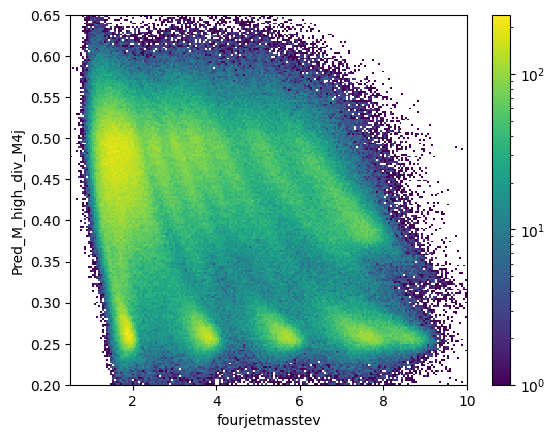

In [40]:
TestingDF["Pred_M_high_div_M4j"] = TestingDF["Pred_M_high"] / 1000 / TestingDF["fourjetmasstev"]
if SanityCheckPlots:
    plt.hist2d(TestingDF["fourjetmasstev"], TestingDF["Pred_M_high_div_M4j"],
               bins = 200, range = [[0.5,10], [0.2,0.65]], norm = "log")
    plt.xlabel("fourjetmasstev")
    plt.ylabel("Pred_M_high_div_M4j")
    plt.colorbar()
    plt.savefig(ResultsDir + "Pred_M_high_div_M4j_vs_M4j.png")

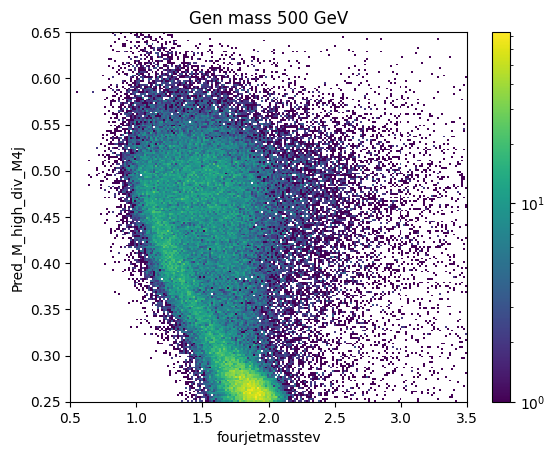

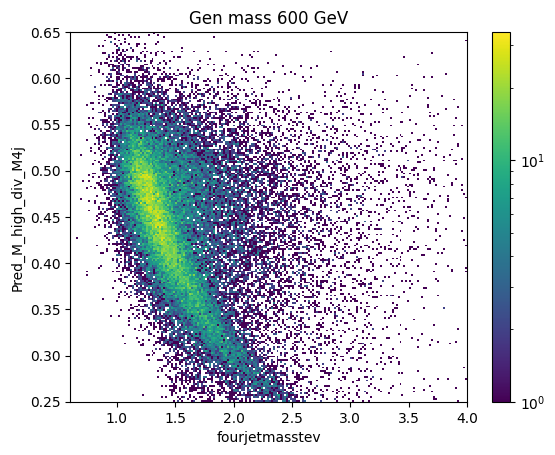

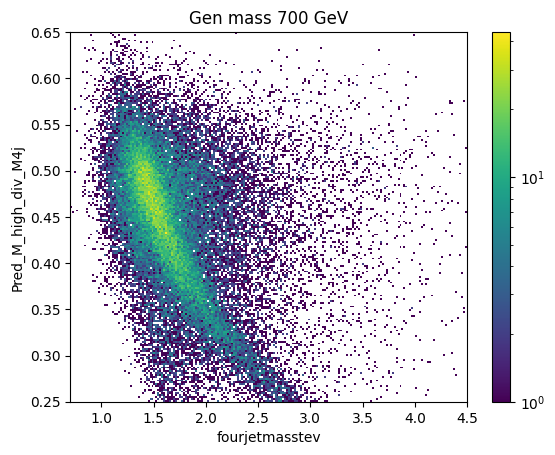

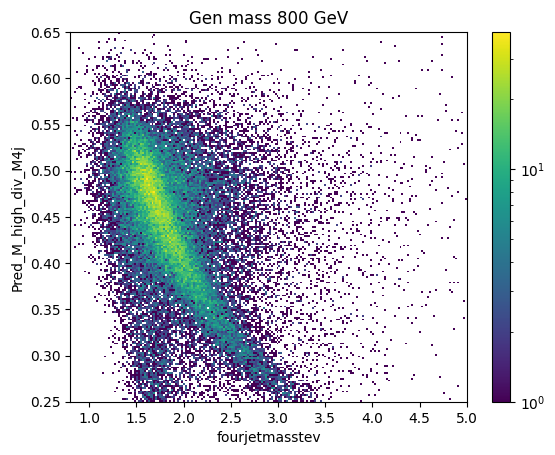

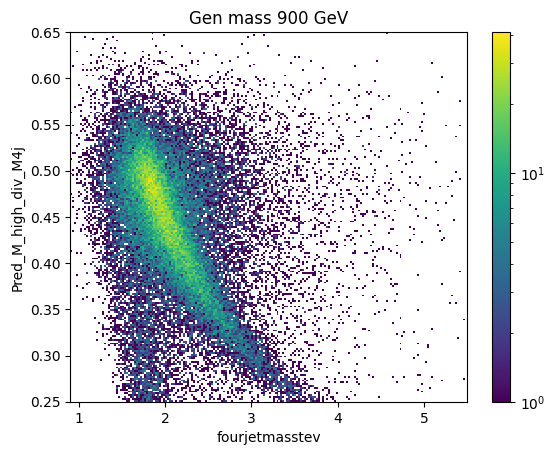

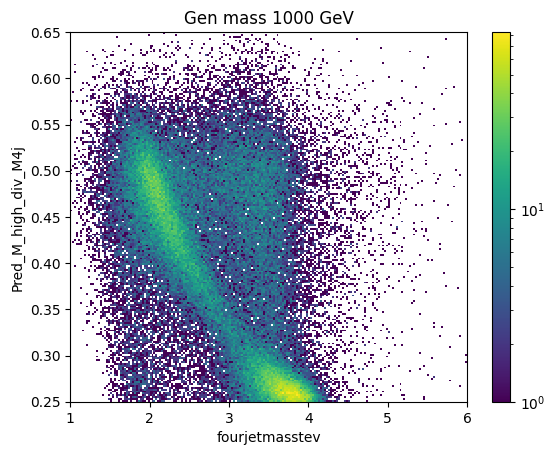

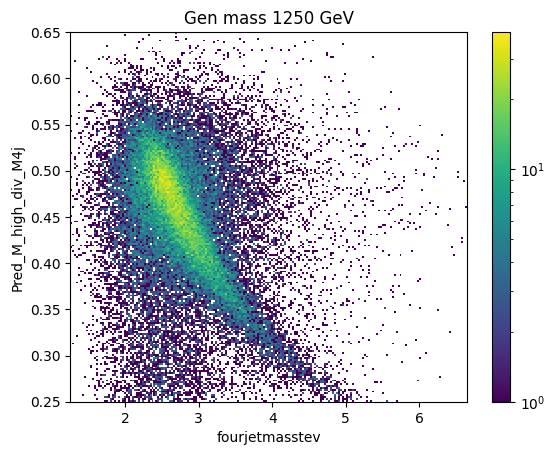

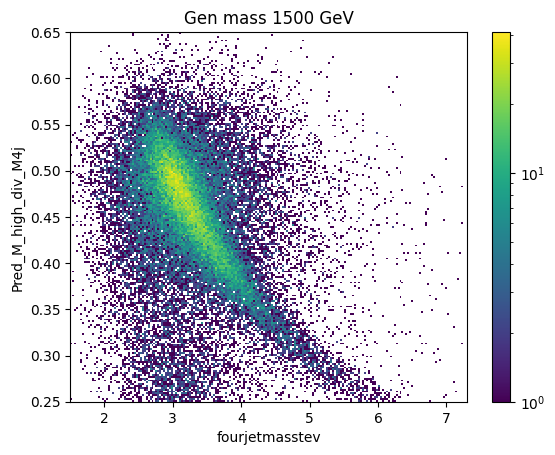

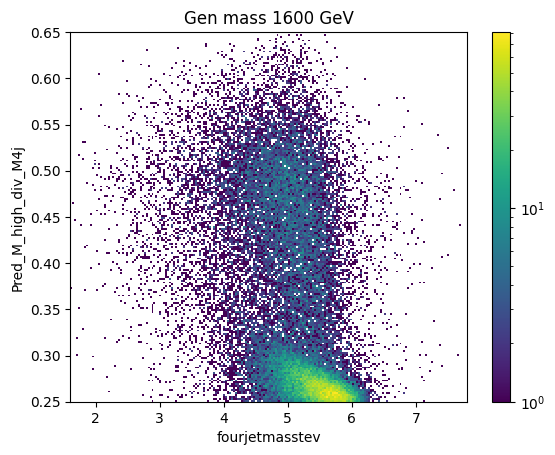

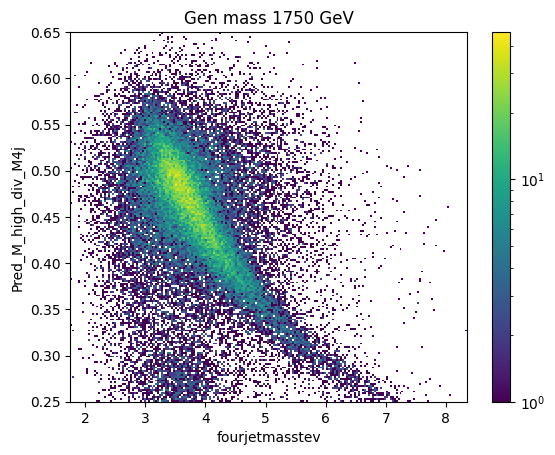

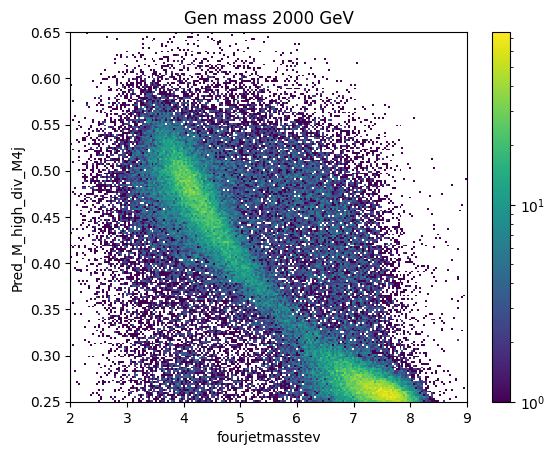

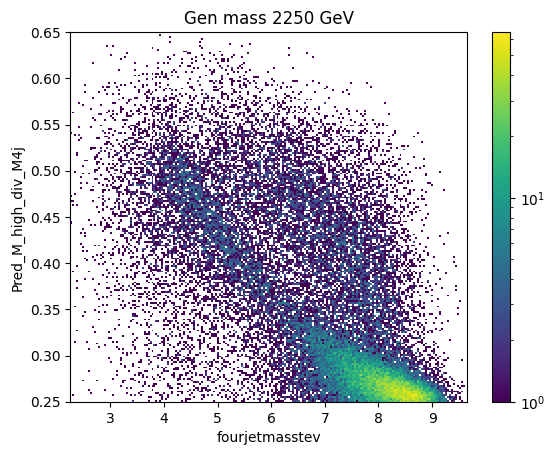

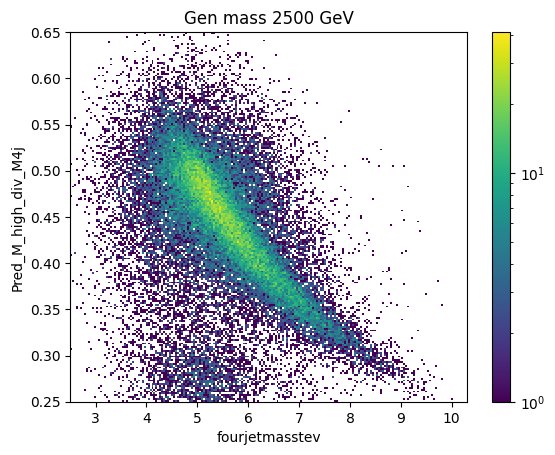

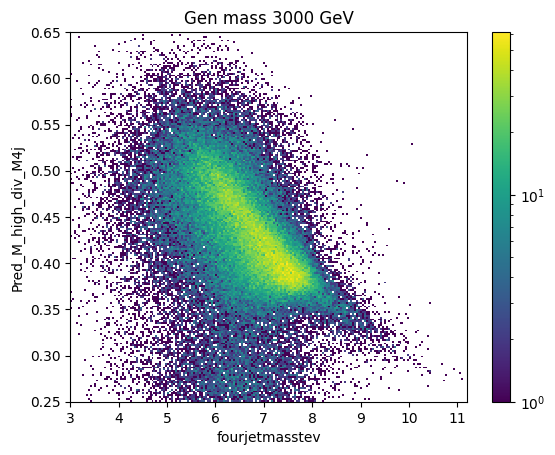

In [41]:
if SanityCheckPlots:
    for i, Mass in enumerate(Masses):
        TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
        if len(TestingDF_temp.index) == 0: continue
        
        plt.figure()    
        plt.hist2d(TestingDF_temp["fourjetmasstev"], TestingDF_temp["Pred_M_high_div_M4j"],
                   bins = 200, range = [[Mass/1000.0, Mass/1000.0 + 3 + 0.4*i], [0.25,0.65]], norm = "log")
        plt.title("Gen mass " + str(Mass) + " GeV")
        plt.xlabel("fourjetmasstev")
        plt.ylabel("Pred_M_high_div_M4j")
        plt.colorbar()
        plt.savefig(ResultsDir + "Pred_M_high_div_M4j_vs_M4j_" + str(Mass) + "GeV.png")